In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential,Model
from keras.layers import Concatenate, Dense,Input, concatenate,Dropout,Flatten
from sklearn.model_selection import KFold
from sklearn.utils import shuffle


In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6



In [3]:
# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32

In [4]:
#get the averaged reflectance from the dataset 
r=np.load('all_angles_r.npy')
c=np.load('cot_500m.npy')


In [5]:
print(r.shape)
r=r.reshape((4000,82,72))
print(r.shape)
print(c.shape)

(4000, 82, 6, 12)
(4000, 82, 72)
(4000, 82)


In [6]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


In [7]:
# DNN over domain -------------------------------------------

def evaluate_model(train_image, test_image, train_label, test_label):

    input_img = Input(shape=(ts,72))
    hn=Flatten()(input_img)
    hn = Dense(82, activation='relu')(hn)#1st fully connected layer
    hn1 =Dense(1024, activation='relu')(hn)
    hn1=Dense(1024, activation='relu')(hn1)
    hn1=Dropout(0.5)(hn1)
    hn1=Dense(8, activation='relu')(hn1) #4th fully connected layer
    out_both = concatenate([hn, hn1], axis=1, name = 'concatenate')
    hn2=Dense(82, activation='linear')(out_both)
    model_m = Model(input_img, outputs=[hn2])
    model_m.summary()


    ltype = 'mean_squared_error'
    ltype2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 128
    eps = 4000

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 50,restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------
    print('test result')

    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [9]:
#5-fold cross validation
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,82,72)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,82,72))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [3200 3201 3202 3203 3204 3205 3206 3207 3208 3209 3210 3211 3212 3213
 3214 3215 3216 3217 3218 3219 3220 3221 3222 3223 3224 3225 3226 3227
 3228 3229 3230 3231 3232 3233 3234 3235 3236 3237 3238 3239 3240 3241
 3242 3243 3244 3245 3246 3247 3248 3249 3250 3251 3252 3253 3254 3255
 3256 3257 3258 3259 3260 3261 3262 3263 3264 3265 3266 3267 3268 3269
 3270 3271 3272 3273 3274 3275 3276 3277 3278 3279 3280 3281 3282 3283
 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297
 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311
 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325
 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339
 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353
 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367
 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381
 3382 3383 3384 3385 3386 33

In [10]:
c# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 82, 72)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 5904)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 82)           484210      flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         84992       dense[0][0]                      
______________________________________________________________________________________________

22/22 [==============================] - 0s 8ms/step - loss: 20.5755 - mean_squared_error: 20.5755 - root_mean_squared_error: 4.5360 - val_loss: 20.5907 - val_mean_squared_error: 20.5907 - val_root_mean_squared_error: 4.5377
Epoch 26/4000
22/22 [==============================] - 0s 8ms/step - loss: 20.2202 - mean_squared_error: 20.2202 - root_mean_squared_error: 4.4967 - val_loss: 20.3207 - val_mean_squared_error: 20.3207 - val_root_mean_squared_error: 4.5079
Epoch 27/4000
22/22 [==============================] - 0s 8ms/step - loss: 19.7711 - mean_squared_error: 19.7711 - root_mean_squared_error: 4.4465 - val_loss: 19.6904 - val_mean_squared_error: 19.6904 - val_root_mean_squared_error: 4.4374
Epoch 28/4000
22/22 [==============================] - 0s 8ms/step - loss: 19.1939 - mean_squared_error: 19.1939 - root_mean_squared_error: 4.3811 - val_loss: 19.3478 - val_mean_squared_error: 19.3478 - val_root_mean_squared_error: 4.3986
Epoch 29/4000
22/22 [==============================] - 0s 

Epoch 59/4000
22/22 [==============================] - 0s 8ms/step - loss: 13.2971 - mean_squared_error: 13.2971 - root_mean_squared_error: 3.6465 - val_loss: 13.4672 - val_mean_squared_error: 13.4672 - val_root_mean_squared_error: 3.6698
Epoch 60/4000
22/22 [==============================] - 0s 8ms/step - loss: 13.2112 - mean_squared_error: 13.2112 - root_mean_squared_error: 3.6347 - val_loss: 13.3641 - val_mean_squared_error: 13.3641 - val_root_mean_squared_error: 3.6557
Epoch 61/4000
22/22 [==============================] - 0s 8ms/step - loss: 13.1409 - mean_squared_error: 13.1409 - root_mean_squared_error: 3.6250 - val_loss: 13.2836 - val_mean_squared_error: 13.2836 - val_root_mean_squared_error: 3.6447
Epoch 62/4000
22/22 [==============================] - 0s 8ms/step - loss: 13.0141 - mean_squared_error: 13.0141 - root_mean_squared_error: 3.6075 - val_loss: 13.1457 - val_mean_squared_error: 13.1457 - val_root_mean_squared_error: 3.6257
Epoch 63/4000
22/22 [=======================

22/22 [==============================] - 0s 8ms/step - loss: 11.0282 - mean_squared_error: 11.0282 - root_mean_squared_error: 3.3209 - val_loss: 11.2997 - val_mean_squared_error: 11.2997 - val_root_mean_squared_error: 3.3615
Epoch 94/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.9755 - mean_squared_error: 10.9755 - root_mean_squared_error: 3.3129 - val_loss: 11.3609 - val_mean_squared_error: 11.3609 - val_root_mean_squared_error: 3.3706
Epoch 95/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.8620 - mean_squared_error: 10.8620 - root_mean_squared_error: 3.2958 - val_loss: 11.2050 - val_mean_squared_error: 11.2050 - val_root_mean_squared_error: 3.3474
Epoch 96/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.8913 - mean_squared_error: 10.8913 - root_mean_squared_error: 3.3002 - val_loss: 11.1557 - val_mean_squared_error: 11.1557 - val_root_mean_squared_error: 3.3400
Epoch 97/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 8ms/step - loss: 9.5774 - mean_squared_error: 9.5774 - root_mean_squared_error: 3.0947 - val_loss: 9.9747 - val_mean_squared_error: 9.9747 - val_root_mean_squared_error: 3.1583
Epoch 128/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.5549 - mean_squared_error: 9.5549 - root_mean_squared_error: 3.0911 - val_loss: 9.9979 - val_mean_squared_error: 9.9979 - val_root_mean_squared_error: 3.1619
Epoch 129/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.5676 - mean_squared_error: 9.5676 - root_mean_squared_error: 3.0931 - val_loss: 9.8997 - val_mean_squared_error: 9.8997 - val_root_mean_squared_error: 3.1464
Epoch 130/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.5421 - mean_squared_error: 9.5421 - root_mean_squared_error: 3.0890 - val_loss: 9.9259 - val_mean_squared_error: 9.9259 - val_root_mean_squared_error: 3.1505
Epoch 131/4000
22/22 [==============================] - 0s 8ms/step - l

Epoch 162/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6172 - mean_squared_error: 8.6172 - root_mean_squared_error: 2.9355 - val_loss: 9.1448 - val_mean_squared_error: 9.1448 - val_root_mean_squared_error: 3.0240
Epoch 163/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6900 - mean_squared_error: 8.6900 - root_mean_squared_error: 2.9479 - val_loss: 9.0603 - val_mean_squared_error: 9.0603 - val_root_mean_squared_error: 3.0100
Epoch 164/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6080 - mean_squared_error: 8.6080 - root_mean_squared_error: 2.9339 - val_loss: 9.0874 - val_mean_squared_error: 9.0874 - val_root_mean_squared_error: 3.0145
Epoch 165/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6472 - mean_squared_error: 8.6472 - root_mean_squared_error: 2.9406 - val_loss: 8.9734 - val_mean_squared_error: 8.9734 - val_root_mean_squared_error: 2.9956
Epoch 166/4000
22/22 [==============================] - 

Epoch 197/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0930 - mean_squared_error: 8.0930 - root_mean_squared_error: 2.8448 - val_loss: 8.5721 - val_mean_squared_error: 8.5721 - val_root_mean_squared_error: 2.9278
Epoch 198/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.1276 - mean_squared_error: 8.1276 - root_mean_squared_error: 2.8509 - val_loss: 8.5249 - val_mean_squared_error: 8.5249 - val_root_mean_squared_error: 2.9197
Epoch 199/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0676 - mean_squared_error: 8.0676 - root_mean_squared_error: 2.8403 - val_loss: 8.5177 - val_mean_squared_error: 8.5177 - val_root_mean_squared_error: 2.9185
Epoch 200/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0929 - mean_squared_error: 8.0929 - root_mean_squared_error: 2.8448 - val_loss: 8.4604 - val_mean_squared_error: 8.4604 - val_root_mean_squared_error: 2.9087
Epoch 201/4000
22/22 [==============================] - 

Epoch 232/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.6935 - mean_squared_error: 7.6935 - root_mean_squared_error: 2.7737 - val_loss: 8.0440 - val_mean_squared_error: 8.0440 - val_root_mean_squared_error: 2.8362
Epoch 233/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.6761 - mean_squared_error: 7.6761 - root_mean_squared_error: 2.7706 - val_loss: 8.1135 - val_mean_squared_error: 8.1135 - val_root_mean_squared_error: 2.8484
Epoch 234/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.6524 - mean_squared_error: 7.6524 - root_mean_squared_error: 2.7663 - val_loss: 8.0640 - val_mean_squared_error: 8.0640 - val_root_mean_squared_error: 2.8397
Epoch 235/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.6540 - mean_squared_error: 7.6540 - root_mean_squared_error: 2.7666 - val_loss: 8.1071 - val_mean_squared_error: 8.1071 - val_root_mean_squared_error: 2.8473
Epoch 236/4000
22/22 [==============================] - 

Epoch 267/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.3760 - mean_squared_error: 7.3760 - root_mean_squared_error: 2.7159 - val_loss: 7.7729 - val_mean_squared_error: 7.7729 - val_root_mean_squared_error: 2.7880
Epoch 268/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.3892 - mean_squared_error: 7.3892 - root_mean_squared_error: 2.7183 - val_loss: 7.7513 - val_mean_squared_error: 7.7513 - val_root_mean_squared_error: 2.7841
Epoch 269/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.4067 - mean_squared_error: 7.4067 - root_mean_squared_error: 2.7215 - val_loss: 7.9113 - val_mean_squared_error: 7.9113 - val_root_mean_squared_error: 2.8127
Epoch 270/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.4305 - mean_squared_error: 7.4305 - root_mean_squared_error: 2.7259 - val_loss: 7.7997 - val_mean_squared_error: 7.7997 - val_root_mean_squared_error: 2.7928
Epoch 271/4000
22/22 [==============================] - 

Epoch 302/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.1429 - mean_squared_error: 7.1429 - root_mean_squared_error: 2.6726 - val_loss: 7.5581 - val_mean_squared_error: 7.5581 - val_root_mean_squared_error: 2.7492
Epoch 303/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.1744 - mean_squared_error: 7.1744 - root_mean_squared_error: 2.6785 - val_loss: 7.5573 - val_mean_squared_error: 7.5573 - val_root_mean_squared_error: 2.7491
Epoch 304/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.1476 - mean_squared_error: 7.1476 - root_mean_squared_error: 2.6735 - val_loss: 7.5478 - val_mean_squared_error: 7.5478 - val_root_mean_squared_error: 2.7473
Epoch 305/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.1947 - mean_squared_error: 7.1947 - root_mean_squared_error: 2.6823 - val_loss: 7.5293 - val_mean_squared_error: 7.5293 - val_root_mean_squared_error: 2.7440
Epoch 306/4000
22/22 [==============================] - 

Epoch 337/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.0278 - mean_squared_error: 7.0278 - root_mean_squared_error: 2.6510 - val_loss: 7.3843 - val_mean_squared_error: 7.3843 - val_root_mean_squared_error: 2.7174
Epoch 338/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.0209 - mean_squared_error: 7.0209 - root_mean_squared_error: 2.6497 - val_loss: 7.3705 - val_mean_squared_error: 7.3705 - val_root_mean_squared_error: 2.7149
Epoch 339/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.9972 - mean_squared_error: 6.9972 - root_mean_squared_error: 2.6452 - val_loss: 7.4545 - val_mean_squared_error: 7.4545 - val_root_mean_squared_error: 2.7303
Epoch 340/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.0351 - mean_squared_error: 7.0351 - root_mean_squared_error: 2.6524 - val_loss: 7.4589 - val_mean_squared_error: 7.4589 - val_root_mean_squared_error: 2.7311
Epoch 341/4000
22/22 [==============================] - 

Epoch 372/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8025 - mean_squared_error: 6.8025 - root_mean_squared_error: 2.6081 - val_loss: 7.3152 - val_mean_squared_error: 7.3152 - val_root_mean_squared_error: 2.7047
Epoch 373/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8148 - mean_squared_error: 6.8148 - root_mean_squared_error: 2.6105 - val_loss: 7.2597 - val_mean_squared_error: 7.2597 - val_root_mean_squared_error: 2.6944
Epoch 374/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7999 - mean_squared_error: 6.7999 - root_mean_squared_error: 2.6076 - val_loss: 7.2461 - val_mean_squared_error: 7.2461 - val_root_mean_squared_error: 2.6919
Epoch 375/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8188 - mean_squared_error: 6.8188 - root_mean_squared_error: 2.6113 - val_loss: 7.2049 - val_mean_squared_error: 7.2049 - val_root_mean_squared_error: 2.6842
Epoch 376/4000
22/22 [==============================] - 

Epoch 407/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7027 - mean_squared_error: 6.7027 - root_mean_squared_error: 2.5890 - val_loss: 7.1430 - val_mean_squared_error: 7.1430 - val_root_mean_squared_error: 2.6726
Epoch 408/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6590 - mean_squared_error: 6.6590 - root_mean_squared_error: 2.5805 - val_loss: 7.0972 - val_mean_squared_error: 7.0972 - val_root_mean_squared_error: 2.6641
Epoch 409/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7302 - mean_squared_error: 6.7302 - root_mean_squared_error: 2.5943 - val_loss: 7.1792 - val_mean_squared_error: 7.1792 - val_root_mean_squared_error: 2.6794
Epoch 410/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7278 - mean_squared_error: 6.7278 - root_mean_squared_error: 2.5938 - val_loss: 7.1350 - val_mean_squared_error: 7.1350 - val_root_mean_squared_error: 2.6711
Epoch 411/4000
22/22 [==============================] - 

Epoch 442/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6043 - mean_squared_error: 6.6043 - root_mean_squared_error: 2.5699 - val_loss: 7.0385 - val_mean_squared_error: 7.0385 - val_root_mean_squared_error: 2.6530
Epoch 443/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5869 - mean_squared_error: 6.5869 - root_mean_squared_error: 2.5665 - val_loss: 7.0125 - val_mean_squared_error: 7.0125 - val_root_mean_squared_error: 2.6481
Epoch 444/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5310 - mean_squared_error: 6.5310 - root_mean_squared_error: 2.5556 - val_loss: 6.9737 - val_mean_squared_error: 6.9737 - val_root_mean_squared_error: 2.6408
Epoch 445/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5555 - mean_squared_error: 6.5555 - root_mean_squared_error: 2.5604 - val_loss: 7.0100 - val_mean_squared_error: 7.0100 - val_root_mean_squared_error: 2.6476
Epoch 446/4000
22/22 [==============================] - 

Epoch 477/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5020 - mean_squared_error: 6.5020 - root_mean_squared_error: 2.5499 - val_loss: 6.9305 - val_mean_squared_error: 6.9305 - val_root_mean_squared_error: 2.6326
Epoch 478/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5050 - mean_squared_error: 6.5050 - root_mean_squared_error: 2.5505 - val_loss: 6.9330 - val_mean_squared_error: 6.9330 - val_root_mean_squared_error: 2.6331
Epoch 479/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5072 - mean_squared_error: 6.5072 - root_mean_squared_error: 2.5509 - val_loss: 6.9336 - val_mean_squared_error: 6.9336 - val_root_mean_squared_error: 2.6332
Epoch 480/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4967 - mean_squared_error: 6.4967 - root_mean_squared_error: 2.5489 - val_loss: 6.9434 - val_mean_squared_error: 6.9434 - val_root_mean_squared_error: 2.6350
Epoch 481/4000
22/22 [==============================] - 

Epoch 512/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4262 - mean_squared_error: 6.4262 - root_mean_squared_error: 2.5350 - val_loss: 6.8943 - val_mean_squared_error: 6.8943 - val_root_mean_squared_error: 2.6257
Epoch 513/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4461 - mean_squared_error: 6.4461 - root_mean_squared_error: 2.5389 - val_loss: 6.8844 - val_mean_squared_error: 6.8844 - val_root_mean_squared_error: 2.6238
Epoch 514/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4746 - mean_squared_error: 6.4746 - root_mean_squared_error: 2.5445 - val_loss: 6.8643 - val_mean_squared_error: 6.8643 - val_root_mean_squared_error: 2.6200
Epoch 515/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4310 - mean_squared_error: 6.4310 - root_mean_squared_error: 2.5359 - val_loss: 6.8654 - val_mean_squared_error: 6.8654 - val_root_mean_squared_error: 2.6202
Epoch 516/4000
22/22 [==============================] - 

Epoch 547/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3247 - mean_squared_error: 6.3247 - root_mean_squared_error: 2.5149 - val_loss: 6.7785 - val_mean_squared_error: 6.7785 - val_root_mean_squared_error: 2.6036
Epoch 548/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3319 - mean_squared_error: 6.3319 - root_mean_squared_error: 2.5163 - val_loss: 6.7403 - val_mean_squared_error: 6.7403 - val_root_mean_squared_error: 2.5962
Epoch 549/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3066 - mean_squared_error: 6.3066 - root_mean_squared_error: 2.5113 - val_loss: 6.8590 - val_mean_squared_error: 6.8590 - val_root_mean_squared_error: 2.6190
Epoch 550/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3513 - mean_squared_error: 6.3513 - root_mean_squared_error: 2.5202 - val_loss: 6.8153 - val_mean_squared_error: 6.8153 - val_root_mean_squared_error: 2.6106
Epoch 551/4000
22/22 [==============================] - 

Epoch 581/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2827 - mean_squared_error: 6.2827 - root_mean_squared_error: 2.5065 - val_loss: 6.7531 - val_mean_squared_error: 6.7531 - val_root_mean_squared_error: 2.5987
Epoch 582/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2927 - mean_squared_error: 6.2927 - root_mean_squared_error: 2.5085 - val_loss: 6.7463 - val_mean_squared_error: 6.7463 - val_root_mean_squared_error: 2.5974
Epoch 583/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2663 - mean_squared_error: 6.2663 - root_mean_squared_error: 2.5033 - val_loss: 6.7276 - val_mean_squared_error: 6.7276 - val_root_mean_squared_error: 2.5938
Epoch 584/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2470 - mean_squared_error: 6.2470 - root_mean_squared_error: 2.4994 - val_loss: 6.7569 - val_mean_squared_error: 6.7569 - val_root_mean_squared_error: 2.5994
Epoch 585/4000
22/22 [==============================] - 

Epoch 616/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1964 - mean_squared_error: 6.1964 - root_mean_squared_error: 2.4893 - val_loss: 6.7059 - val_mean_squared_error: 6.7059 - val_root_mean_squared_error: 2.5896
Epoch 617/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2284 - mean_squared_error: 6.2284 - root_mean_squared_error: 2.4957 - val_loss: 6.7438 - val_mean_squared_error: 6.7438 - val_root_mean_squared_error: 2.5969
Epoch 618/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2025 - mean_squared_error: 6.2025 - root_mean_squared_error: 2.4905 - val_loss: 6.7828 - val_mean_squared_error: 6.7828 - val_root_mean_squared_error: 2.6044
Epoch 619/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2684 - mean_squared_error: 6.2684 - root_mean_squared_error: 2.5037 - val_loss: 6.7412 - val_mean_squared_error: 6.7412 - val_root_mean_squared_error: 2.5964
Epoch 620/4000
22/22 [==============================] - 

Epoch 651/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1638 - mean_squared_error: 6.1638 - root_mean_squared_error: 2.4827 - val_loss: 6.7330 - val_mean_squared_error: 6.7330 - val_root_mean_squared_error: 2.5948
Epoch 652/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1930 - mean_squared_error: 6.1930 - root_mean_squared_error: 2.4886 - val_loss: 6.7444 - val_mean_squared_error: 6.7444 - val_root_mean_squared_error: 2.5970
Epoch 653/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1652 - mean_squared_error: 6.1652 - root_mean_squared_error: 2.4830 - val_loss: 6.6942 - val_mean_squared_error: 6.6942 - val_root_mean_squared_error: 2.5873
Epoch 654/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1483 - mean_squared_error: 6.1483 - root_mean_squared_error: 2.4796 - val_loss: 6.6832 - val_mean_squared_error: 6.6832 - val_root_mean_squared_error: 2.5852
Epoch 655/4000
22/22 [==============================] - 

Epoch 686/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1186 - mean_squared_error: 6.1186 - root_mean_squared_error: 2.4736 - val_loss: 6.6958 - val_mean_squared_error: 6.6958 - val_root_mean_squared_error: 2.5876
Epoch 687/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1341 - mean_squared_error: 6.1341 - root_mean_squared_error: 2.4767 - val_loss: 6.6569 - val_mean_squared_error: 6.6569 - val_root_mean_squared_error: 2.5801
Epoch 688/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1086 - mean_squared_error: 6.1086 - root_mean_squared_error: 2.4716 - val_loss: 6.7054 - val_mean_squared_error: 6.7054 - val_root_mean_squared_error: 2.5895
Epoch 689/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2090 - mean_squared_error: 6.2090 - root_mean_squared_error: 2.4918 - val_loss: 6.6690 - val_mean_squared_error: 6.6690 - val_root_mean_squared_error: 2.5824
Epoch 690/4000
22/22 [==============================] - 

Epoch 721/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0764 - mean_squared_error: 6.0764 - root_mean_squared_error: 2.4650 - val_loss: 6.6019 - val_mean_squared_error: 6.6019 - val_root_mean_squared_error: 2.5694
Epoch 722/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0727 - mean_squared_error: 6.0727 - root_mean_squared_error: 2.4643 - val_loss: 6.6271 - val_mean_squared_error: 6.6271 - val_root_mean_squared_error: 2.5743
Epoch 723/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0666 - mean_squared_error: 6.0666 - root_mean_squared_error: 2.4630 - val_loss: 6.6217 - val_mean_squared_error: 6.6217 - val_root_mean_squared_error: 2.5733
Epoch 724/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1445 - mean_squared_error: 6.1445 - root_mean_squared_error: 2.4788 - val_loss: 6.6306 - val_mean_squared_error: 6.6306 - val_root_mean_squared_error: 2.5750
Epoch 725/4000
22/22 [==============================] - 

Epoch 756/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0459 - mean_squared_error: 6.0459 - root_mean_squared_error: 2.4588 - val_loss: 6.6296 - val_mean_squared_error: 6.6296 - val_root_mean_squared_error: 2.5748
Epoch 757/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0765 - mean_squared_error: 6.0765 - root_mean_squared_error: 2.4651 - val_loss: 6.6837 - val_mean_squared_error: 6.6837 - val_root_mean_squared_error: 2.5853
Epoch 758/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0674 - mean_squared_error: 6.0674 - root_mean_squared_error: 2.4632 - val_loss: 6.5992 - val_mean_squared_error: 6.5992 - val_root_mean_squared_error: 2.5689
Epoch 759/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0601 - mean_squared_error: 6.0601 - root_mean_squared_error: 2.4617 - val_loss: 6.6631 - val_mean_squared_error: 6.6631 - val_root_mean_squared_error: 2.5813
Epoch 760/4000
22/22 [==============================] - 

Epoch 791/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0115 - mean_squared_error: 6.0115 - root_mean_squared_error: 2.4518 - val_loss: 6.5427 - val_mean_squared_error: 6.5427 - val_root_mean_squared_error: 2.5579
Epoch 792/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9996 - mean_squared_error: 5.9996 - root_mean_squared_error: 2.4494 - val_loss: 6.6018 - val_mean_squared_error: 6.6018 - val_root_mean_squared_error: 2.5694
Epoch 793/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0576 - mean_squared_error: 6.0576 - root_mean_squared_error: 2.4612 - val_loss: 6.5658 - val_mean_squared_error: 6.5658 - val_root_mean_squared_error: 2.5624
Epoch 794/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9989 - mean_squared_error: 5.9989 - root_mean_squared_error: 2.4493 - val_loss: 6.5996 - val_mean_squared_error: 6.5996 - val_root_mean_squared_error: 2.5690
Epoch 795/4000
22/22 [==============================] - 

Epoch 826/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0028 - mean_squared_error: 6.0028 - root_mean_squared_error: 2.4501 - val_loss: 6.5816 - val_mean_squared_error: 6.5816 - val_root_mean_squared_error: 2.5655
Epoch 827/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9546 - mean_squared_error: 5.9546 - root_mean_squared_error: 2.4402 - val_loss: 6.5317 - val_mean_squared_error: 6.5317 - val_root_mean_squared_error: 2.5557
Epoch 828/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9589 - mean_squared_error: 5.9589 - root_mean_squared_error: 2.4411 - val_loss: 6.6527 - val_mean_squared_error: 6.6527 - val_root_mean_squared_error: 2.5793
Epoch 829/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0224 - mean_squared_error: 6.0224 - root_mean_squared_error: 2.4541 - val_loss: 6.5678 - val_mean_squared_error: 6.5678 - val_root_mean_squared_error: 2.5628
Epoch 830/4000
22/22 [==============================] - 

Epoch 861/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9634 - mean_squared_error: 5.9634 - root_mean_squared_error: 2.4420 - val_loss: 6.5203 - val_mean_squared_error: 6.5203 - val_root_mean_squared_error: 2.5535
Epoch 862/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9484 - mean_squared_error: 5.9484 - root_mean_squared_error: 2.4389 - val_loss: 6.5224 - val_mean_squared_error: 6.5224 - val_root_mean_squared_error: 2.5539
Epoch 863/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9994 - mean_squared_error: 5.9994 - root_mean_squared_error: 2.4494 - val_loss: 6.7054 - val_mean_squared_error: 6.7054 - val_root_mean_squared_error: 2.5895
Epoch 864/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0149 - mean_squared_error: 6.0149 - root_mean_squared_error: 2.4525 - val_loss: 6.5457 - val_mean_squared_error: 6.5457 - val_root_mean_squared_error: 2.5585
Epoch 865/4000
22/22 [==============================] - 

Epoch 896/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9580 - mean_squared_error: 5.9580 - root_mean_squared_error: 2.4409 - val_loss: 6.4886 - val_mean_squared_error: 6.4886 - val_root_mean_squared_error: 2.5473
Epoch 897/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9182 - mean_squared_error: 5.9182 - root_mean_squared_error: 2.4327 - val_loss: 6.5015 - val_mean_squared_error: 6.5015 - val_root_mean_squared_error: 2.5498
Epoch 898/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9740 - mean_squared_error: 5.9740 - root_mean_squared_error: 2.4442 - val_loss: 6.5974 - val_mean_squared_error: 6.5974 - val_root_mean_squared_error: 2.5685
Epoch 899/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9227 - mean_squared_error: 5.9227 - root_mean_squared_error: 2.4337 - val_loss: 6.4796 - val_mean_squared_error: 6.4796 - val_root_mean_squared_error: 2.5455
Epoch 900/4000
22/22 [==============================] - 

Epoch 931/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9191 - mean_squared_error: 5.9191 - root_mean_squared_error: 2.4329 - val_loss: 6.4945 - val_mean_squared_error: 6.4945 - val_root_mean_squared_error: 2.5484
Epoch 932/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9273 - mean_squared_error: 5.9273 - root_mean_squared_error: 2.4346 - val_loss: 6.4989 - val_mean_squared_error: 6.4989 - val_root_mean_squared_error: 2.5493
Epoch 933/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9248 - mean_squared_error: 5.9248 - root_mean_squared_error: 2.4341 - val_loss: 6.4945 - val_mean_squared_error: 6.4945 - val_root_mean_squared_error: 2.5484
Epoch 934/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9389 - mean_squared_error: 5.9389 - root_mean_squared_error: 2.4370 - val_loss: 6.5458 - val_mean_squared_error: 6.5458 - val_root_mean_squared_error: 2.5585
Epoch 935/4000
22/22 [==============================] - 

Epoch 966/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8844 - mean_squared_error: 5.8844 - root_mean_squared_error: 2.4258 - val_loss: 6.4684 - val_mean_squared_error: 6.4684 - val_root_mean_squared_error: 2.5433
Epoch 967/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9414 - mean_squared_error: 5.9414 - root_mean_squared_error: 2.4375 - val_loss: 6.6358 - val_mean_squared_error: 6.6358 - val_root_mean_squared_error: 2.5760
Epoch 968/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9286 - mean_squared_error: 5.9286 - root_mean_squared_error: 2.4349 - val_loss: 6.4863 - val_mean_squared_error: 6.4863 - val_root_mean_squared_error: 2.5468
Epoch 969/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8720 - mean_squared_error: 5.8720 - root_mean_squared_error: 2.4232 - val_loss: 6.4775 - val_mean_squared_error: 6.4775 - val_root_mean_squared_error: 2.5451
Epoch 970/4000
22/22 [==============================] - 

Epoch 1001/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8731 - mean_squared_error: 5.8731 - root_mean_squared_error: 2.4234 - val_loss: 6.5091 - val_mean_squared_error: 6.5091 - val_root_mean_squared_error: 2.5513
Epoch 1002/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8727 - mean_squared_error: 5.8727 - root_mean_squared_error: 2.4234 - val_loss: 6.5226 - val_mean_squared_error: 6.5226 - val_root_mean_squared_error: 2.5539
Epoch 1003/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9084 - mean_squared_error: 5.9084 - root_mean_squared_error: 2.4307 - val_loss: 6.4535 - val_mean_squared_error: 6.4535 - val_root_mean_squared_error: 2.5404
Epoch 1004/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9017 - mean_squared_error: 5.9017 - root_mean_squared_error: 2.4293 - val_loss: 6.4607 - val_mean_squared_error: 6.4607 - val_root_mean_squared_error: 2.5418
Epoch 1005/4000
22/22 [=============================

22/22 [==============================] - 0s 8ms/step - loss: 5.8555 - mean_squared_error: 5.8555 - root_mean_squared_error: 2.4198 - val_loss: 6.4538 - val_mean_squared_error: 6.4538 - val_root_mean_squared_error: 2.5404
Epoch 1036/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8487 - mean_squared_error: 5.8487 - root_mean_squared_error: 2.4184 - val_loss: 6.5075 - val_mean_squared_error: 6.5075 - val_root_mean_squared_error: 2.5510
Epoch 1037/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8849 - mean_squared_error: 5.8849 - root_mean_squared_error: 2.4259 - val_loss: 6.4808 - val_mean_squared_error: 6.4808 - val_root_mean_squared_error: 2.5457
Epoch 1038/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8676 - mean_squared_error: 5.8676 - root_mean_squared_error: 2.4223 - val_loss: 6.4657 - val_mean_squared_error: 6.4657 - val_root_mean_squared_error: 2.5428
Epoch 1039/4000
22/22 [==============================] - 0s 8ms/step

Epoch 1070/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8517 - mean_squared_error: 5.8517 - root_mean_squared_error: 2.4190 - val_loss: 6.4502 - val_mean_squared_error: 6.4502 - val_root_mean_squared_error: 2.5397
Epoch 1071/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8398 - mean_squared_error: 5.8398 - root_mean_squared_error: 2.4166 - val_loss: 6.4506 - val_mean_squared_error: 6.4506 - val_root_mean_squared_error: 2.5398
Epoch 1072/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8086 - mean_squared_error: 5.8086 - root_mean_squared_error: 2.4101 - val_loss: 6.4233 - val_mean_squared_error: 6.4233 - val_root_mean_squared_error: 2.5344
Epoch 1073/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7869 - mean_squared_error: 5.7869 - root_mean_squared_error: 2.4056 - val_loss: 6.4379 - val_mean_squared_error: 6.4379 - val_root_mean_squared_error: 2.5373
Epoch 1074/4000
22/22 [=============================

22/22 [==============================] - 0s 8ms/step - loss: 5.7742 - mean_squared_error: 5.7742 - root_mean_squared_error: 2.4030 - val_loss: 6.4058 - val_mean_squared_error: 6.4058 - val_root_mean_squared_error: 2.5310
Epoch 1105/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7855 - mean_squared_error: 5.7855 - root_mean_squared_error: 2.4053 - val_loss: 6.3971 - val_mean_squared_error: 6.3971 - val_root_mean_squared_error: 2.5293
Epoch 1106/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7587 - mean_squared_error: 5.7587 - root_mean_squared_error: 2.3997 - val_loss: 6.4004 - val_mean_squared_error: 6.4004 - val_root_mean_squared_error: 2.5299
Epoch 1107/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7984 - mean_squared_error: 5.7984 - root_mean_squared_error: 2.4080 - val_loss: 6.4129 - val_mean_squared_error: 6.4129 - val_root_mean_squared_error: 2.5324
Epoch 1108/4000
22/22 [==============================] - 0s 8ms/step

Epoch 1139/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7233 - mean_squared_error: 5.7233 - root_mean_squared_error: 2.3923 - val_loss: 6.4292 - val_mean_squared_error: 6.4292 - val_root_mean_squared_error: 2.5356
Epoch 1140/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7162 - mean_squared_error: 5.7162 - root_mean_squared_error: 2.3908 - val_loss: 6.3422 - val_mean_squared_error: 6.3422 - val_root_mean_squared_error: 2.5184
Epoch 1141/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7390 - mean_squared_error: 5.7390 - root_mean_squared_error: 2.3956 - val_loss: 6.3783 - val_mean_squared_error: 6.3783 - val_root_mean_squared_error: 2.5255
Epoch 1142/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7383 - mean_squared_error: 5.7383 - root_mean_squared_error: 2.3955 - val_loss: 6.3693 - val_mean_squared_error: 6.3693 - val_root_mean_squared_error: 2.5238
Epoch 1143/4000
22/22 [=============================

22/22 [==============================] - 0s 8ms/step - loss: 5.7203 - mean_squared_error: 5.7203 - root_mean_squared_error: 2.3917 - val_loss: 6.4568 - val_mean_squared_error: 6.4568 - val_root_mean_squared_error: 2.5410
Epoch 1174/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7307 - mean_squared_error: 5.7307 - root_mean_squared_error: 2.3939 - val_loss: 6.3750 - val_mean_squared_error: 6.3750 - val_root_mean_squared_error: 2.5249
Epoch 1175/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7378 - mean_squared_error: 5.7378 - root_mean_squared_error: 2.3954 - val_loss: 6.4097 - val_mean_squared_error: 6.4097 - val_root_mean_squared_error: 2.5317
Epoch 1176/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7281 - mean_squared_error: 5.7281 - root_mean_squared_error: 2.3933 - val_loss: 6.3849 - val_mean_squared_error: 6.3849 - val_root_mean_squared_error: 2.5268
Epoch 1177/4000
22/22 [==============================] - 0s 8ms/step

22/22 [==============================] - 0s 8ms/step - loss: 40.3829 - mean_squared_error: 40.3829 - root_mean_squared_error: 6.3546 - val_loss: 38.2709 - val_mean_squared_error: 38.2709 - val_root_mean_squared_error: 6.1863
Epoch 7/4000
22/22 [==============================] - 0s 8ms/step - loss: 37.6066 - mean_squared_error: 37.6066 - root_mean_squared_error: 6.1324 - val_loss: 36.2302 - val_mean_squared_error: 36.2302 - val_root_mean_squared_error: 6.0192
Epoch 8/4000
22/22 [==============================] - 0s 7ms/step - loss: 35.4527 - mean_squared_error: 35.4527 - root_mean_squared_error: 5.9542 - val_loss: 34.0451 - val_mean_squared_error: 34.0451 - val_root_mean_squared_error: 5.8348
Epoch 9/4000
22/22 [==============================] - 0s 8ms/step - loss: 33.2779 - mean_squared_error: 33.2779 - root_mean_squared_error: 5.7686 - val_loss: 31.6595 - val_mean_squared_error: 31.6595 - val_root_mean_squared_error: 5.6267
Epoch 10/4000
22/22 [==============================] - 0s 8ms

Epoch 40/4000
22/22 [==============================] - 0s 8ms/step - loss: 14.7861 - mean_squared_error: 14.7861 - root_mean_squared_error: 3.8453 - val_loss: 14.8041 - val_mean_squared_error: 14.8041 - val_root_mean_squared_error: 3.8476
Epoch 41/4000
22/22 [==============================] - 0s 8ms/step - loss: 14.7155 - mean_squared_error: 14.7155 - root_mean_squared_error: 3.8361 - val_loss: 14.5850 - val_mean_squared_error: 14.5850 - val_root_mean_squared_error: 3.8190
Epoch 42/4000
22/22 [==============================] - 0s 8ms/step - loss: 14.4743 - mean_squared_error: 14.4743 - root_mean_squared_error: 3.8045 - val_loss: 14.4614 - val_mean_squared_error: 14.4614 - val_root_mean_squared_error: 3.8028
Epoch 43/4000
22/22 [==============================] - 0s 8ms/step - loss: 14.3965 - mean_squared_error: 14.3965 - root_mean_squared_error: 3.7943 - val_loss: 14.4607 - val_mean_squared_error: 14.4607 - val_root_mean_squared_error: 3.8027
Epoch 44/4000
22/22 [=======================

22/22 [==============================] - 0s 8ms/step - loss: 11.6362 - mean_squared_error: 11.6362 - root_mean_squared_error: 3.4112 - val_loss: 11.7441 - val_mean_squared_error: 11.7441 - val_root_mean_squared_error: 3.4270
Epoch 75/4000
22/22 [==============================] - 0s 8ms/step - loss: 11.5313 - mean_squared_error: 11.5313 - root_mean_squared_error: 3.3958 - val_loss: 11.6834 - val_mean_squared_error: 11.6834 - val_root_mean_squared_error: 3.4181
Epoch 76/4000
22/22 [==============================] - 0s 8ms/step - loss: 11.4923 - mean_squared_error: 11.4923 - root_mean_squared_error: 3.3900 - val_loss: 11.6708 - val_mean_squared_error: 11.6708 - val_root_mean_squared_error: 3.4163
Epoch 77/4000
22/22 [==============================] - 0s 8ms/step - loss: 11.5075 - mean_squared_error: 11.5075 - root_mean_squared_error: 3.3923 - val_loss: 11.5851 - val_mean_squared_error: 11.5851 - val_root_mean_squared_error: 3.4037
Epoch 78/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 8ms/step - loss: 10.0600 - mean_squared_error: 10.0600 - root_mean_squared_error: 3.1718 - val_loss: 10.3227 - val_mean_squared_error: 10.3227 - val_root_mean_squared_error: 3.2129
Epoch 109/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.9419 - mean_squared_error: 9.9419 - root_mean_squared_error: 3.1531 - val_loss: 10.1827 - val_mean_squared_error: 10.1827 - val_root_mean_squared_error: 3.1910
Epoch 110/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.9190 - mean_squared_error: 9.9190 - root_mean_squared_error: 3.1494 - val_loss: 10.1119 - val_mean_squared_error: 10.1119 - val_root_mean_squared_error: 3.1799
Epoch 111/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.8479 - mean_squared_error: 9.8479 - root_mean_squared_error: 3.1381 - val_loss: 10.1316 - val_mean_squared_error: 10.1316 - val_root_mean_squared_error: 3.1830
Epoch 112/4000
22/22 [==============================] - 0s 7m

Epoch 143/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.8345 - mean_squared_error: 8.8345 - root_mean_squared_error: 2.9723 - val_loss: 9.0932 - val_mean_squared_error: 9.0932 - val_root_mean_squared_error: 3.0155
Epoch 144/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.7783 - mean_squared_error: 8.7783 - root_mean_squared_error: 2.9628 - val_loss: 9.0532 - val_mean_squared_error: 9.0532 - val_root_mean_squared_error: 3.0089
Epoch 145/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.7205 - mean_squared_error: 8.7205 - root_mean_squared_error: 2.9530 - val_loss: 9.0369 - val_mean_squared_error: 9.0369 - val_root_mean_squared_error: 3.0061
Epoch 146/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.7030 - mean_squared_error: 8.7030 - root_mean_squared_error: 2.9501 - val_loss: 9.0839 - val_mean_squared_error: 9.0839 - val_root_mean_squared_error: 3.0139
Epoch 147/4000
22/22 [==============================] - 

Epoch 178/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0197 - mean_squared_error: 8.0197 - root_mean_squared_error: 2.8319 - val_loss: 8.4606 - val_mean_squared_error: 8.4606 - val_root_mean_squared_error: 2.9087
Epoch 179/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0340 - mean_squared_error: 8.0340 - root_mean_squared_error: 2.8344 - val_loss: 8.4568 - val_mean_squared_error: 8.4568 - val_root_mean_squared_error: 2.9081
Epoch 180/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0332 - mean_squared_error: 8.0332 - root_mean_squared_error: 2.8343 - val_loss: 8.3576 - val_mean_squared_error: 8.3576 - val_root_mean_squared_error: 2.8910
Epoch 181/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.9930 - mean_squared_error: 7.9930 - root_mean_squared_error: 2.8272 - val_loss: 8.3978 - val_mean_squared_error: 8.3978 - val_root_mean_squared_error: 2.8979
Epoch 182/4000
22/22 [==============================] - 

Epoch 213/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.5423 - mean_squared_error: 7.5423 - root_mean_squared_error: 2.7463 - val_loss: 7.9741 - val_mean_squared_error: 7.9741 - val_root_mean_squared_error: 2.8238
Epoch 214/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.5061 - mean_squared_error: 7.5061 - root_mean_squared_error: 2.7397 - val_loss: 7.8655 - val_mean_squared_error: 7.8655 - val_root_mean_squared_error: 2.8046
Epoch 215/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.5091 - mean_squared_error: 7.5091 - root_mean_squared_error: 2.7403 - val_loss: 7.9562 - val_mean_squared_error: 7.9562 - val_root_mean_squared_error: 2.8207
Epoch 216/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.5487 - mean_squared_error: 7.5487 - root_mean_squared_error: 2.7475 - val_loss: 7.9502 - val_mean_squared_error: 7.9502 - val_root_mean_squared_error: 2.8196
Epoch 217/4000
22/22 [==============================] - 

Epoch 248/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.2582 - mean_squared_error: 7.2582 - root_mean_squared_error: 2.6941 - val_loss: 7.6240 - val_mean_squared_error: 7.6240 - val_root_mean_squared_error: 2.7612
Epoch 249/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.2209 - mean_squared_error: 7.2209 - root_mean_squared_error: 2.6872 - val_loss: 7.5620 - val_mean_squared_error: 7.5620 - val_root_mean_squared_error: 2.7499
Epoch 250/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.2293 - mean_squared_error: 7.2293 - root_mean_squared_error: 2.6887 - val_loss: 7.5860 - val_mean_squared_error: 7.5860 - val_root_mean_squared_error: 2.7543
Epoch 251/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.1728 - mean_squared_error: 7.1728 - root_mean_squared_error: 2.6782 - val_loss: 7.5255 - val_mean_squared_error: 7.5255 - val_root_mean_squared_error: 2.7433
Epoch 252/4000
22/22 [==============================] - 

Epoch 283/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.9804 - mean_squared_error: 6.9804 - root_mean_squared_error: 2.6420 - val_loss: 7.3951 - val_mean_squared_error: 7.3951 - val_root_mean_squared_error: 2.7194
Epoch 284/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.9922 - mean_squared_error: 6.9922 - root_mean_squared_error: 2.6443 - val_loss: 7.2822 - val_mean_squared_error: 7.2822 - val_root_mean_squared_error: 2.6986
Epoch 285/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8801 - mean_squared_error: 6.8801 - root_mean_squared_error: 2.6230 - val_loss: 7.2883 - val_mean_squared_error: 7.2883 - val_root_mean_squared_error: 2.6997
Epoch 286/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8946 - mean_squared_error: 6.8946 - root_mean_squared_error: 2.6257 - val_loss: 7.2795 - val_mean_squared_error: 7.2795 - val_root_mean_squared_error: 2.6980
Epoch 287/4000
22/22 [==============================] - 

Epoch 318/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7746 - mean_squared_error: 6.7746 - root_mean_squared_error: 2.6028 - val_loss: 7.1503 - val_mean_squared_error: 7.1503 - val_root_mean_squared_error: 2.6740
Epoch 319/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.7206 - mean_squared_error: 6.7206 - root_mean_squared_error: 2.5924 - val_loss: 7.1012 - val_mean_squared_error: 7.1012 - val_root_mean_squared_error: 2.6648
Epoch 320/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.7457 - mean_squared_error: 6.7457 - root_mean_squared_error: 2.5972 - val_loss: 7.1311 - val_mean_squared_error: 7.1311 - val_root_mean_squared_error: 2.6704
Epoch 321/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.7189 - mean_squared_error: 6.7189 - root_mean_squared_error: 2.5921 - val_loss: 7.1859 - val_mean_squared_error: 7.1859 - val_root_mean_squared_error: 2.6807
Epoch 322/4000
22/22 [==============================] - 

Epoch 353/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5379 - mean_squared_error: 6.5379 - root_mean_squared_error: 2.5569 - val_loss: 6.9766 - val_mean_squared_error: 6.9766 - val_root_mean_squared_error: 2.6413
Epoch 354/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5752 - mean_squared_error: 6.5752 - root_mean_squared_error: 2.5642 - val_loss: 7.0262 - val_mean_squared_error: 7.0262 - val_root_mean_squared_error: 2.6507
Epoch 355/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5719 - mean_squared_error: 6.5719 - root_mean_squared_error: 2.5636 - val_loss: 7.0694 - val_mean_squared_error: 7.0694 - val_root_mean_squared_error: 2.6588
Epoch 356/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6064 - mean_squared_error: 6.6064 - root_mean_squared_error: 2.5703 - val_loss: 7.0810 - val_mean_squared_error: 7.0810 - val_root_mean_squared_error: 2.6610
Epoch 357/4000
22/22 [==============================] - 

Epoch 388/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4152 - mean_squared_error: 6.4152 - root_mean_squared_error: 2.5328 - val_loss: 6.8730 - val_mean_squared_error: 6.8730 - val_root_mean_squared_error: 2.6216
Epoch 389/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4041 - mean_squared_error: 6.4041 - root_mean_squared_error: 2.5306 - val_loss: 6.9156 - val_mean_squared_error: 6.9156 - val_root_mean_squared_error: 2.6297
Epoch 390/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4310 - mean_squared_error: 6.4310 - root_mean_squared_error: 2.5359 - val_loss: 6.9047 - val_mean_squared_error: 6.9047 - val_root_mean_squared_error: 2.6277
Epoch 391/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4148 - mean_squared_error: 6.4148 - root_mean_squared_error: 2.5327 - val_loss: 6.9008 - val_mean_squared_error: 6.9008 - val_root_mean_squared_error: 2.6269
Epoch 392/4000
22/22 [==============================] - 

Epoch 423/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3314 - mean_squared_error: 6.3314 - root_mean_squared_error: 2.5162 - val_loss: 6.7641 - val_mean_squared_error: 6.7641 - val_root_mean_squared_error: 2.6008
Epoch 424/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3068 - mean_squared_error: 6.3068 - root_mean_squared_error: 2.5113 - val_loss: 6.8540 - val_mean_squared_error: 6.8540 - val_root_mean_squared_error: 2.6180
Epoch 425/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3213 - mean_squared_error: 6.3213 - root_mean_squared_error: 2.5142 - val_loss: 6.7997 - val_mean_squared_error: 6.7997 - val_root_mean_squared_error: 2.6076
Epoch 426/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3079 - mean_squared_error: 6.3079 - root_mean_squared_error: 2.5115 - val_loss: 6.7885 - val_mean_squared_error: 6.7885 - val_root_mean_squared_error: 2.6055
Epoch 427/4000
22/22 [==============================] - 

Epoch 458/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2041 - mean_squared_error: 6.2041 - root_mean_squared_error: 2.4908 - val_loss: 6.6783 - val_mean_squared_error: 6.6783 - val_root_mean_squared_error: 2.5842
Epoch 459/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1916 - mean_squared_error: 6.1916 - root_mean_squared_error: 2.4883 - val_loss: 6.7094 - val_mean_squared_error: 6.7094 - val_root_mean_squared_error: 2.5903
Epoch 460/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2052 - mean_squared_error: 6.2052 - root_mean_squared_error: 2.4910 - val_loss: 6.6883 - val_mean_squared_error: 6.6883 - val_root_mean_squared_error: 2.5862
Epoch 461/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2048 - mean_squared_error: 6.2048 - root_mean_squared_error: 2.4909 - val_loss: 6.6619 - val_mean_squared_error: 6.6619 - val_root_mean_squared_error: 2.5811
Epoch 462/4000
22/22 [==============================] - 

Epoch 493/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1665 - mean_squared_error: 6.1665 - root_mean_squared_error: 2.4832 - val_loss: 6.6748 - val_mean_squared_error: 6.6748 - val_root_mean_squared_error: 2.5836
Epoch 494/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1463 - mean_squared_error: 6.1463 - root_mean_squared_error: 2.4792 - val_loss: 6.6086 - val_mean_squared_error: 6.6086 - val_root_mean_squared_error: 2.5707
Epoch 495/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0908 - mean_squared_error: 6.0908 - root_mean_squared_error: 2.4680 - val_loss: 6.6298 - val_mean_squared_error: 6.6298 - val_root_mean_squared_error: 2.5748
Epoch 496/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1296 - mean_squared_error: 6.1296 - root_mean_squared_error: 2.4758 - val_loss: 6.6647 - val_mean_squared_error: 6.6647 - val_root_mean_squared_error: 2.5816
Epoch 497/4000
22/22 [==============================] - 

Epoch 528/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1081 - mean_squared_error: 6.1081 - root_mean_squared_error: 2.4715 - val_loss: 6.6251 - val_mean_squared_error: 6.6251 - val_root_mean_squared_error: 2.5739
Epoch 529/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0760 - mean_squared_error: 6.0760 - root_mean_squared_error: 2.4650 - val_loss: 6.5792 - val_mean_squared_error: 6.5792 - val_root_mean_squared_error: 2.5650
Epoch 530/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0857 - mean_squared_error: 6.0857 - root_mean_squared_error: 2.4669 - val_loss: 6.5307 - val_mean_squared_error: 6.5307 - val_root_mean_squared_error: 2.5555
Epoch 531/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0565 - mean_squared_error: 6.0565 - root_mean_squared_error: 2.4610 - val_loss: 6.5715 - val_mean_squared_error: 6.5715 - val_root_mean_squared_error: 2.5635
Epoch 532/4000
22/22 [==============================] - 

Epoch 563/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0583 - mean_squared_error: 6.0583 - root_mean_squared_error: 2.4613 - val_loss: 6.5175 - val_mean_squared_error: 6.5175 - val_root_mean_squared_error: 2.5529
Epoch 564/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9827 - mean_squared_error: 5.9827 - root_mean_squared_error: 2.4459 - val_loss: 6.6121 - val_mean_squared_error: 6.6121 - val_root_mean_squared_error: 2.5714
Epoch 565/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0481 - mean_squared_error: 6.0481 - root_mean_squared_error: 2.4593 - val_loss: 6.5216 - val_mean_squared_error: 6.5216 - val_root_mean_squared_error: 2.5537
Epoch 566/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0146 - mean_squared_error: 6.0146 - root_mean_squared_error: 2.4525 - val_loss: 6.5121 - val_mean_squared_error: 6.5121 - val_root_mean_squared_error: 2.5519
Epoch 567/4000
22/22 [==============================] - 

Epoch 598/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9371 - mean_squared_error: 5.9371 - root_mean_squared_error: 2.4366 - val_loss: 6.5237 - val_mean_squared_error: 6.5237 - val_root_mean_squared_error: 2.5542
Epoch 599/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9439 - mean_squared_error: 5.9439 - root_mean_squared_error: 2.4380 - val_loss: 6.4463 - val_mean_squared_error: 6.4463 - val_root_mean_squared_error: 2.5390
Epoch 600/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9184 - mean_squared_error: 5.9184 - root_mean_squared_error: 2.4328 - val_loss: 6.5522 - val_mean_squared_error: 6.5522 - val_root_mean_squared_error: 2.5597
Epoch 601/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0024 - mean_squared_error: 6.0024 - root_mean_squared_error: 2.4500 - val_loss: 6.4760 - val_mean_squared_error: 6.4760 - val_root_mean_squared_error: 2.5448
Epoch 602/4000
22/22 [==============================] - 

Epoch 633/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9194 - mean_squared_error: 5.9194 - root_mean_squared_error: 2.4330 - val_loss: 6.4669 - val_mean_squared_error: 6.4669 - val_root_mean_squared_error: 2.5430
Epoch 634/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9431 - mean_squared_error: 5.9431 - root_mean_squared_error: 2.4378 - val_loss: 6.4266 - val_mean_squared_error: 6.4266 - val_root_mean_squared_error: 2.5351
Epoch 635/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9127 - mean_squared_error: 5.9127 - root_mean_squared_error: 2.4316 - val_loss: 6.4846 - val_mean_squared_error: 6.4846 - val_root_mean_squared_error: 2.5465
Epoch 636/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9312 - mean_squared_error: 5.9312 - root_mean_squared_error: 2.4354 - val_loss: 6.4280 - val_mean_squared_error: 6.4280 - val_root_mean_squared_error: 2.5354
Epoch 637/4000
22/22 [==============================] - 

Epoch 668/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8938 - mean_squared_error: 5.8938 - root_mean_squared_error: 2.4277 - val_loss: 6.3938 - val_mean_squared_error: 6.3938 - val_root_mean_squared_error: 2.5286
Epoch 669/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8589 - mean_squared_error: 5.8589 - root_mean_squared_error: 2.4205 - val_loss: 6.3587 - val_mean_squared_error: 6.3587 - val_root_mean_squared_error: 2.5217
Epoch 670/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8441 - mean_squared_error: 5.8441 - root_mean_squared_error: 2.4175 - val_loss: 6.3543 - val_mean_squared_error: 6.3543 - val_root_mean_squared_error: 2.5208
Epoch 671/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8541 - mean_squared_error: 5.8541 - root_mean_squared_error: 2.4195 - val_loss: 6.4079 - val_mean_squared_error: 6.4079 - val_root_mean_squared_error: 2.5314
Epoch 672/4000
22/22 [==============================] - 

Epoch 703/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8613 - mean_squared_error: 5.8613 - root_mean_squared_error: 2.4210 - val_loss: 6.3882 - val_mean_squared_error: 6.3882 - val_root_mean_squared_error: 2.5275
Epoch 704/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8578 - mean_squared_error: 5.8578 - root_mean_squared_error: 2.4203 - val_loss: 6.4080 - val_mean_squared_error: 6.4080 - val_root_mean_squared_error: 2.5314
Epoch 705/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8714 - mean_squared_error: 5.8714 - root_mean_squared_error: 2.4231 - val_loss: 6.4181 - val_mean_squared_error: 6.4181 - val_root_mean_squared_error: 2.5334
Epoch 706/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8509 - mean_squared_error: 5.8509 - root_mean_squared_error: 2.4189 - val_loss: 6.3637 - val_mean_squared_error: 6.3637 - val_root_mean_squared_error: 2.5226
Epoch 707/4000
22/22 [==============================] - 

Epoch 738/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7896 - mean_squared_error: 5.7896 - root_mean_squared_error: 2.4061 - val_loss: 6.3837 - val_mean_squared_error: 6.3837 - val_root_mean_squared_error: 2.5266
Epoch 739/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8179 - mean_squared_error: 5.8179 - root_mean_squared_error: 2.4120 - val_loss: 6.2947 - val_mean_squared_error: 6.2947 - val_root_mean_squared_error: 2.5089
Epoch 740/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8093 - mean_squared_error: 5.8093 - root_mean_squared_error: 2.4102 - val_loss: 6.3231 - val_mean_squared_error: 6.3231 - val_root_mean_squared_error: 2.5146
Epoch 741/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7943 - mean_squared_error: 5.7943 - root_mean_squared_error: 2.4071 - val_loss: 6.3187 - val_mean_squared_error: 6.3187 - val_root_mean_squared_error: 2.5137
Epoch 742/4000
22/22 [==============================] - 

Epoch 773/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.7976 - mean_squared_error: 5.7976 - root_mean_squared_error: 2.4078 - val_loss: 6.3469 - val_mean_squared_error: 6.3469 - val_root_mean_squared_error: 2.5193
Epoch 774/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.7775 - mean_squared_error: 5.7775 - root_mean_squared_error: 2.4036 - val_loss: 6.2958 - val_mean_squared_error: 6.2958 - val_root_mean_squared_error: 2.5092
Epoch 775/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7697 - mean_squared_error: 5.7697 - root_mean_squared_error: 2.4020 - val_loss: 6.3133 - val_mean_squared_error: 6.3133 - val_root_mean_squared_error: 2.5126
Epoch 776/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7670 - mean_squared_error: 5.7670 - root_mean_squared_error: 2.4014 - val_loss: 6.3100 - val_mean_squared_error: 6.3100 - val_root_mean_squared_error: 2.5120
Epoch 777/4000
22/22 [==============================] - 

Epoch 808/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7619 - mean_squared_error: 5.7619 - root_mean_squared_error: 2.4004 - val_loss: 6.2281 - val_mean_squared_error: 6.2281 - val_root_mean_squared_error: 2.4956
Epoch 809/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7506 - mean_squared_error: 5.7506 - root_mean_squared_error: 2.3980 - val_loss: 6.2724 - val_mean_squared_error: 6.2724 - val_root_mean_squared_error: 2.5045
Epoch 810/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7315 - mean_squared_error: 5.7315 - root_mean_squared_error: 2.3940 - val_loss: 6.2807 - val_mean_squared_error: 6.2807 - val_root_mean_squared_error: 2.5061
Epoch 811/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7787 - mean_squared_error: 5.7787 - root_mean_squared_error: 2.4039 - val_loss: 6.3449 - val_mean_squared_error: 6.3449 - val_root_mean_squared_error: 2.5189
Epoch 812/4000
22/22 [==============================] - 

Epoch 843/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7283 - mean_squared_error: 5.7283 - root_mean_squared_error: 2.3934 - val_loss: 6.2874 - val_mean_squared_error: 6.2874 - val_root_mean_squared_error: 2.5075
Epoch 844/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7554 - mean_squared_error: 5.7554 - root_mean_squared_error: 2.3990 - val_loss: 6.2700 - val_mean_squared_error: 6.2700 - val_root_mean_squared_error: 2.5040
Epoch 845/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7503 - mean_squared_error: 5.7503 - root_mean_squared_error: 2.3980 - val_loss: 6.2683 - val_mean_squared_error: 6.2683 - val_root_mean_squared_error: 2.5037
Epoch 846/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7042 - mean_squared_error: 5.7042 - root_mean_squared_error: 2.3883 - val_loss: 6.2754 - val_mean_squared_error: 6.2754 - val_root_mean_squared_error: 2.5051
Epoch 847/4000
22/22 [==============================] - 

Epoch 878/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7034 - mean_squared_error: 5.7034 - root_mean_squared_error: 2.3882 - val_loss: 6.2874 - val_mean_squared_error: 6.2874 - val_root_mean_squared_error: 2.5075
Epoch 879/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7066 - mean_squared_error: 5.7066 - root_mean_squared_error: 2.3888 - val_loss: 6.2267 - val_mean_squared_error: 6.2267 - val_root_mean_squared_error: 2.4953
Epoch 880/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6785 - mean_squared_error: 5.6785 - root_mean_squared_error: 2.3830 - val_loss: 6.2954 - val_mean_squared_error: 6.2954 - val_root_mean_squared_error: 2.5091
Epoch 881/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7387 - mean_squared_error: 5.7387 - root_mean_squared_error: 2.3955 - val_loss: 6.2674 - val_mean_squared_error: 6.2674 - val_root_mean_squared_error: 2.5035
Epoch 882/4000
22/22 [==============================] - 

Epoch 913/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7208 - mean_squared_error: 5.7208 - root_mean_squared_error: 2.3918 - val_loss: 6.2191 - val_mean_squared_error: 6.2191 - val_root_mean_squared_error: 2.4938
Epoch 914/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.6411 - mean_squared_error: 5.6411 - root_mean_squared_error: 2.3751 - val_loss: 6.2495 - val_mean_squared_error: 6.2495 - val_root_mean_squared_error: 2.4999
Epoch 915/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7043 - mean_squared_error: 5.7043 - root_mean_squared_error: 2.3884 - val_loss: 6.2511 - val_mean_squared_error: 6.2511 - val_root_mean_squared_error: 2.5002
Epoch 916/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.7102 - mean_squared_error: 5.7102 - root_mean_squared_error: 2.3896 - val_loss: 6.2753 - val_mean_squared_error: 6.2753 - val_root_mean_squared_error: 2.5051
Epoch 917/4000
22/22 [==============================] - 

Epoch 948/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6920 - mean_squared_error: 5.6920 - root_mean_squared_error: 2.3858 - val_loss: 6.2536 - val_mean_squared_error: 6.2536 - val_root_mean_squared_error: 2.5007
Epoch 949/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7046 - mean_squared_error: 5.7046 - root_mean_squared_error: 2.3884 - val_loss: 6.1956 - val_mean_squared_error: 6.1956 - val_root_mean_squared_error: 2.4891
Epoch 950/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7262 - mean_squared_error: 5.7262 - root_mean_squared_error: 2.3929 - val_loss: 6.2284 - val_mean_squared_error: 6.2284 - val_root_mean_squared_error: 2.4957
Epoch 951/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6608 - mean_squared_error: 5.6608 - root_mean_squared_error: 2.3792 - val_loss: 6.2439 - val_mean_squared_error: 6.2439 - val_root_mean_squared_error: 2.4988
Epoch 952/4000
22/22 [==============================] - 

Epoch 983/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6344 - mean_squared_error: 5.6344 - root_mean_squared_error: 2.3737 - val_loss: 6.2218 - val_mean_squared_error: 6.2218 - val_root_mean_squared_error: 2.4944
Epoch 984/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6798 - mean_squared_error: 5.6798 - root_mean_squared_error: 2.3832 - val_loss: 6.2660 - val_mean_squared_error: 6.2660 - val_root_mean_squared_error: 2.5032
Epoch 985/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6921 - mean_squared_error: 5.6921 - root_mean_squared_error: 2.3858 - val_loss: 6.1771 - val_mean_squared_error: 6.1771 - val_root_mean_squared_error: 2.4854
Epoch 986/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6250 - mean_squared_error: 5.6250 - root_mean_squared_error: 2.3717 - val_loss: 6.2740 - val_mean_squared_error: 6.2740 - val_root_mean_squared_error: 2.5048
Epoch 987/4000
22/22 [==============================] - 

Epoch 1018/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6189 - mean_squared_error: 5.6189 - root_mean_squared_error: 2.3704 - val_loss: 6.1705 - val_mean_squared_error: 6.1705 - val_root_mean_squared_error: 2.4840
Epoch 1019/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5961 - mean_squared_error: 5.5961 - root_mean_squared_error: 2.3656 - val_loss: 6.2794 - val_mean_squared_error: 6.2794 - val_root_mean_squared_error: 2.5059
Epoch 1020/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6972 - mean_squared_error: 5.6972 - root_mean_squared_error: 2.3869 - val_loss: 6.2225 - val_mean_squared_error: 6.2225 - val_root_mean_squared_error: 2.4945
Epoch 1021/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6577 - mean_squared_error: 5.6577 - root_mean_squared_error: 2.3786 - val_loss: 6.2193 - val_mean_squared_error: 6.2193 - val_root_mean_squared_error: 2.4939
Epoch 1022/4000
22/22 [=============================

22/22 [==============================] - 0s 7ms/step - loss: 5.6081 - mean_squared_error: 5.6081 - root_mean_squared_error: 2.3681 - val_loss: 6.1936 - val_mean_squared_error: 6.1936 - val_root_mean_squared_error: 2.4887
Epoch 1053/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5969 - mean_squared_error: 5.5969 - root_mean_squared_error: 2.3658 - val_loss: 6.2004 - val_mean_squared_error: 6.2004 - val_root_mean_squared_error: 2.4901
Epoch 1054/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6124 - mean_squared_error: 5.6124 - root_mean_squared_error: 2.3691 - val_loss: 6.1890 - val_mean_squared_error: 6.1890 - val_root_mean_squared_error: 2.4878
Epoch 1055/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6200 - mean_squared_error: 5.6200 - root_mean_squared_error: 2.3707 - val_loss: 6.2317 - val_mean_squared_error: 6.2317 - val_root_mean_squared_error: 2.4963
Epoch 1056/4000
22/22 [==============================] - 0s 8ms/step

Epoch 1/4000
22/22 [==============================] - 1s 14ms/step - loss: 178.6728 - mean_squared_error: 178.6728 - root_mean_squared_error: 13.3430 - val_loss: 102.9226 - val_mean_squared_error: 102.9226 - val_root_mean_squared_error: 10.1451
Epoch 2/4000
22/22 [==============================] - 0s 8ms/step - loss: 92.0582 - mean_squared_error: 92.0582 - root_mean_squared_error: 9.5903 - val_loss: 70.9963 - val_mean_squared_error: 70.9963 - val_root_mean_squared_error: 8.4259
Epoch 3/4000
22/22 [==============================] - 0s 7ms/step - loss: 65.8832 - mean_squared_error: 65.8832 - root_mean_squared_error: 8.1153 - val_loss: 54.9358 - val_mean_squared_error: 54.9358 - val_root_mean_squared_error: 7.4119
Epoch 4/4000
22/22 [==============================] - 0s 7ms/step - loss: 52.0505 - mean_squared_error: 52.0505 - root_mean_squared_error: 7.2140 - val_loss: 46.4103 - val_mean_squared_error: 46.4103 - val_root_mean_squared_error: 6.8125
Epoch 5/4000
22/22 [=====================

22/22 [==============================] - 0s 8ms/step - loss: 15.7219 - mean_squared_error: 15.7219 - root_mean_squared_error: 3.9651 - val_loss: 15.8786 - val_mean_squared_error: 15.8786 - val_root_mean_squared_error: 3.9848
Epoch 36/4000
22/22 [==============================] - 0s 8ms/step - loss: 15.5046 - mean_squared_error: 15.5046 - root_mean_squared_error: 3.9376 - val_loss: 15.5753 - val_mean_squared_error: 15.5753 - val_root_mean_squared_error: 3.9466
Epoch 37/4000
22/22 [==============================] - 0s 8ms/step - loss: 15.3430 - mean_squared_error: 15.3430 - root_mean_squared_error: 3.9170 - val_loss: 15.4381 - val_mean_squared_error: 15.4381 - val_root_mean_squared_error: 3.9291
Epoch 38/4000
22/22 [==============================] - 0s 7ms/step - loss: 15.0585 - mean_squared_error: 15.0585 - root_mean_squared_error: 3.8805 - val_loss: 15.1591 - val_mean_squared_error: 15.1591 - val_root_mean_squared_error: 3.8935
Epoch 39/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 7ms/step - loss: 12.3023 - mean_squared_error: 12.3023 - root_mean_squared_error: 3.5075 - val_loss: 12.6287 - val_mean_squared_error: 12.6287 - val_root_mean_squared_error: 3.5537
Epoch 70/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.2963 - mean_squared_error: 12.2963 - root_mean_squared_error: 3.5066 - val_loss: 12.5804 - val_mean_squared_error: 12.5804 - val_root_mean_squared_error: 3.5469
Epoch 71/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.2644 - mean_squared_error: 12.2644 - root_mean_squared_error: 3.5020 - val_loss: 12.4600 - val_mean_squared_error: 12.4600 - val_root_mean_squared_error: 3.5299
Epoch 72/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.0908 - mean_squared_error: 12.0908 - root_mean_squared_error: 3.4772 - val_loss: 12.4305 - val_mean_squared_error: 12.4305 - val_root_mean_squared_error: 3.5257
Epoch 73/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 7ms/step - loss: 10.3662 - mean_squared_error: 10.3662 - root_mean_squared_error: 3.2196 - val_loss: 10.6952 - val_mean_squared_error: 10.6952 - val_root_mean_squared_error: 3.2704
Epoch 104/4000
22/22 [==============================] - 0s 7ms/step - loss: 10.2571 - mean_squared_error: 10.2571 - root_mean_squared_error: 3.2027 - val_loss: 10.7427 - val_mean_squared_error: 10.7427 - val_root_mean_squared_error: 3.2776
Epoch 105/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.2986 - mean_squared_error: 10.2986 - root_mean_squared_error: 3.2091 - val_loss: 10.6056 - val_mean_squared_error: 10.6056 - val_root_mean_squared_error: 3.2566
Epoch 106/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.2372 - mean_squared_error: 10.2372 - root_mean_squared_error: 3.1996 - val_loss: 10.5413 - val_mean_squared_error: 10.5413 - val_root_mean_squared_error: 3.2467
Epoch 107/4000
22/22 [==============================] -

22/22 [==============================] - 0s 7ms/step - loss: 9.0244 - mean_squared_error: 9.0244 - root_mean_squared_error: 3.0040 - val_loss: 9.4539 - val_mean_squared_error: 9.4539 - val_root_mean_squared_error: 3.0747
Epoch 138/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.9957 - mean_squared_error: 8.9957 - root_mean_squared_error: 2.9993 - val_loss: 9.4042 - val_mean_squared_error: 9.4042 - val_root_mean_squared_error: 3.0666
Epoch 139/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.9833 - mean_squared_error: 8.9833 - root_mean_squared_error: 2.9972 - val_loss: 9.4627 - val_mean_squared_error: 9.4627 - val_root_mean_squared_error: 3.0762
Epoch 140/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.0921 - mean_squared_error: 9.0921 - root_mean_squared_error: 3.0153 - val_loss: 9.4326 - val_mean_squared_error: 9.4326 - val_root_mean_squared_error: 3.0713
Epoch 141/4000
22/22 [==============================] - 0s 8ms/step - l

Epoch 172/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.2526 - mean_squared_error: 8.2526 - root_mean_squared_error: 2.8727 - val_loss: 8.6861 - val_mean_squared_error: 8.6861 - val_root_mean_squared_error: 2.9472
Epoch 173/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.2335 - mean_squared_error: 8.2335 - root_mean_squared_error: 2.8694 - val_loss: 8.6591 - val_mean_squared_error: 8.6591 - val_root_mean_squared_error: 2.9426
Epoch 174/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.2526 - mean_squared_error: 8.2526 - root_mean_squared_error: 2.8727 - val_loss: 8.6392 - val_mean_squared_error: 8.6392 - val_root_mean_squared_error: 2.9392
Epoch 175/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.1920 - mean_squared_error: 8.1920 - root_mean_squared_error: 2.8622 - val_loss: 8.5991 - val_mean_squared_error: 8.5991 - val_root_mean_squared_error: 2.9324
Epoch 176/4000
22/22 [==============================] - 

Epoch 207/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.7522 - mean_squared_error: 7.7522 - root_mean_squared_error: 2.7843 - val_loss: 8.1613 - val_mean_squared_error: 8.1613 - val_root_mean_squared_error: 2.8568
Epoch 208/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.7404 - mean_squared_error: 7.7404 - root_mean_squared_error: 2.7822 - val_loss: 8.1038 - val_mean_squared_error: 8.1038 - val_root_mean_squared_error: 2.8467
Epoch 209/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.7211 - mean_squared_error: 7.7211 - root_mean_squared_error: 2.7787 - val_loss: 8.1824 - val_mean_squared_error: 8.1824 - val_root_mean_squared_error: 2.8605
Epoch 210/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.7720 - mean_squared_error: 7.7720 - root_mean_squared_error: 2.7878 - val_loss: 8.1676 - val_mean_squared_error: 8.1676 - val_root_mean_squared_error: 2.8579
Epoch 211/4000
22/22 [==============================] - 

Epoch 242/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.4390 - mean_squared_error: 7.4390 - root_mean_squared_error: 2.7275 - val_loss: 7.8892 - val_mean_squared_error: 7.8892 - val_root_mean_squared_error: 2.8088
Epoch 243/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4384 - mean_squared_error: 7.4384 - root_mean_squared_error: 2.7273 - val_loss: 7.8711 - val_mean_squared_error: 7.8711 - val_root_mean_squared_error: 2.8056
Epoch 244/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4668 - mean_squared_error: 7.4668 - root_mean_squared_error: 2.7325 - val_loss: 7.8787 - val_mean_squared_error: 7.8787 - val_root_mean_squared_error: 2.8069
Epoch 245/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4228 - mean_squared_error: 7.4228 - root_mean_squared_error: 2.7245 - val_loss: 7.7998 - val_mean_squared_error: 7.7998 - val_root_mean_squared_error: 2.7928
Epoch 246/4000
22/22 [==============================] - 

Epoch 277/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1800 - mean_squared_error: 7.1800 - root_mean_squared_error: 2.6795 - val_loss: 7.6382 - val_mean_squared_error: 7.6382 - val_root_mean_squared_error: 2.7637
Epoch 278/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1738 - mean_squared_error: 7.1738 - root_mean_squared_error: 2.6784 - val_loss: 7.6143 - val_mean_squared_error: 7.6143 - val_root_mean_squared_error: 2.7594
Epoch 279/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.2035 - mean_squared_error: 7.2035 - root_mean_squared_error: 2.6839 - val_loss: 7.5921 - val_mean_squared_error: 7.5921 - val_root_mean_squared_error: 2.7554
Epoch 280/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1632 - mean_squared_error: 7.1632 - root_mean_squared_error: 2.6764 - val_loss: 7.6441 - val_mean_squared_error: 7.6441 - val_root_mean_squared_error: 2.7648
Epoch 281/4000
22/22 [==============================] - 

Epoch 312/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.9201 - mean_squared_error: 6.9201 - root_mean_squared_error: 2.6306 - val_loss: 7.3046 - val_mean_squared_error: 7.3046 - val_root_mean_squared_error: 2.7027
Epoch 313/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8973 - mean_squared_error: 6.8973 - root_mean_squared_error: 2.6263 - val_loss: 7.3340 - val_mean_squared_error: 7.3340 - val_root_mean_squared_error: 2.7081
Epoch 314/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8943 - mean_squared_error: 6.8943 - root_mean_squared_error: 2.6257 - val_loss: 7.3040 - val_mean_squared_error: 7.3040 - val_root_mean_squared_error: 2.7026
Epoch 315/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8574 - mean_squared_error: 6.8574 - root_mean_squared_error: 2.6187 - val_loss: 7.3808 - val_mean_squared_error: 7.3808 - val_root_mean_squared_error: 2.7168
Epoch 316/4000
22/22 [==============================] - 

Epoch 347/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6956 - mean_squared_error: 6.6956 - root_mean_squared_error: 2.5876 - val_loss: 7.2009 - val_mean_squared_error: 7.2009 - val_root_mean_squared_error: 2.6834
Epoch 348/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6946 - mean_squared_error: 6.6946 - root_mean_squared_error: 2.5874 - val_loss: 7.1699 - val_mean_squared_error: 7.1699 - val_root_mean_squared_error: 2.6777
Epoch 349/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.7277 - mean_squared_error: 6.7277 - root_mean_squared_error: 2.5938 - val_loss: 7.1448 - val_mean_squared_error: 7.1448 - val_root_mean_squared_error: 2.6730
Epoch 350/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6800 - mean_squared_error: 6.6800 - root_mean_squared_error: 2.5846 - val_loss: 7.0936 - val_mean_squared_error: 7.0936 - val_root_mean_squared_error: 2.6634
Epoch 351/4000
22/22 [==============================] - 

Epoch 382/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5949 - mean_squared_error: 6.5949 - root_mean_squared_error: 2.5680 - val_loss: 6.9833 - val_mean_squared_error: 6.9833 - val_root_mean_squared_error: 2.6426
Epoch 383/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5479 - mean_squared_error: 6.5479 - root_mean_squared_error: 2.5589 - val_loss: 7.0594 - val_mean_squared_error: 7.0594 - val_root_mean_squared_error: 2.6569
Epoch 384/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6087 - mean_squared_error: 6.6087 - root_mean_squared_error: 2.5707 - val_loss: 6.9808 - val_mean_squared_error: 6.9808 - val_root_mean_squared_error: 2.6421
Epoch 385/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.5371 - mean_squared_error: 6.5371 - root_mean_squared_error: 2.5568 - val_loss: 7.0385 - val_mean_squared_error: 7.0385 - val_root_mean_squared_error: 2.6530
Epoch 386/4000
22/22 [==============================] - 

Epoch 417/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4601 - mean_squared_error: 6.4601 - root_mean_squared_error: 2.5417 - val_loss: 6.9067 - val_mean_squared_error: 6.9067 - val_root_mean_squared_error: 2.6281
Epoch 418/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4334 - mean_squared_error: 6.4334 - root_mean_squared_error: 2.5364 - val_loss: 6.8997 - val_mean_squared_error: 6.8997 - val_root_mean_squared_error: 2.6267
Epoch 419/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4052 - mean_squared_error: 6.4052 - root_mean_squared_error: 2.5308 - val_loss: 6.9164 - val_mean_squared_error: 6.9164 - val_root_mean_squared_error: 2.6299
Epoch 420/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4527 - mean_squared_error: 6.4527 - root_mean_squared_error: 2.5402 - val_loss: 6.8985 - val_mean_squared_error: 6.8985 - val_root_mean_squared_error: 2.6265
Epoch 421/4000
22/22 [==============================] - 

Epoch 452/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3877 - mean_squared_error: 6.3877 - root_mean_squared_error: 2.5274 - val_loss: 6.8067 - val_mean_squared_error: 6.8067 - val_root_mean_squared_error: 2.6090
Epoch 453/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3805 - mean_squared_error: 6.3805 - root_mean_squared_error: 2.5260 - val_loss: 6.7710 - val_mean_squared_error: 6.7710 - val_root_mean_squared_error: 2.6021
Epoch 454/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2915 - mean_squared_error: 6.2915 - root_mean_squared_error: 2.5083 - val_loss: 6.7681 - val_mean_squared_error: 6.7681 - val_root_mean_squared_error: 2.6015
Epoch 455/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3199 - mean_squared_error: 6.3199 - root_mean_squared_error: 2.5139 - val_loss: 6.7710 - val_mean_squared_error: 6.7710 - val_root_mean_squared_error: 2.6021
Epoch 456/4000
22/22 [==============================] - 

Epoch 487/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3345 - mean_squared_error: 6.3345 - root_mean_squared_error: 2.5168 - val_loss: 6.7575 - val_mean_squared_error: 6.7575 - val_root_mean_squared_error: 2.5995
Epoch 488/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3205 - mean_squared_error: 6.3205 - root_mean_squared_error: 2.5140 - val_loss: 6.7210 - val_mean_squared_error: 6.7210 - val_root_mean_squared_error: 2.5925
Epoch 489/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2557 - mean_squared_error: 6.2557 - root_mean_squared_error: 2.5011 - val_loss: 6.7160 - val_mean_squared_error: 6.7160 - val_root_mean_squared_error: 2.5915
Epoch 490/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2388 - mean_squared_error: 6.2388 - root_mean_squared_error: 2.4978 - val_loss: 6.6777 - val_mean_squared_error: 6.6777 - val_root_mean_squared_error: 2.5841
Epoch 491/4000
22/22 [==============================] - 

Epoch 522/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1682 - mean_squared_error: 6.1682 - root_mean_squared_error: 2.4836 - val_loss: 6.6496 - val_mean_squared_error: 6.6496 - val_root_mean_squared_error: 2.5787
Epoch 523/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1895 - mean_squared_error: 6.1895 - root_mean_squared_error: 2.4879 - val_loss: 6.6069 - val_mean_squared_error: 6.6069 - val_root_mean_squared_error: 2.5704
Epoch 524/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1963 - mean_squared_error: 6.1963 - root_mean_squared_error: 2.4892 - val_loss: 6.6636 - val_mean_squared_error: 6.6636 - val_root_mean_squared_error: 2.5814
Epoch 525/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1680 - mean_squared_error: 6.1680 - root_mean_squared_error: 2.4835 - val_loss: 6.6991 - val_mean_squared_error: 6.6991 - val_root_mean_squared_error: 2.5883
Epoch 526/4000
22/22 [==============================] - 

Epoch 557/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1589 - mean_squared_error: 6.1589 - root_mean_squared_error: 2.4817 - val_loss: 6.5782 - val_mean_squared_error: 6.5782 - val_root_mean_squared_error: 2.5648
Epoch 558/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1459 - mean_squared_error: 6.1459 - root_mean_squared_error: 2.4791 - val_loss: 6.5979 - val_mean_squared_error: 6.5979 - val_root_mean_squared_error: 2.5686
Epoch 559/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1046 - mean_squared_error: 6.1046 - root_mean_squared_error: 2.4707 - val_loss: 6.5571 - val_mean_squared_error: 6.5571 - val_root_mean_squared_error: 2.5607
Epoch 560/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1066 - mean_squared_error: 6.1066 - root_mean_squared_error: 2.4711 - val_loss: 6.5937 - val_mean_squared_error: 6.5937 - val_root_mean_squared_error: 2.5678
Epoch 561/4000
22/22 [==============================] - 

Epoch 592/4000
22/22 [==============================] - 0s 9ms/step - loss: 6.0770 - mean_squared_error: 6.0770 - root_mean_squared_error: 2.4652 - val_loss: 6.5460 - val_mean_squared_error: 6.5460 - val_root_mean_squared_error: 2.5585
Epoch 593/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0956 - mean_squared_error: 6.0956 - root_mean_squared_error: 2.4689 - val_loss: 6.5115 - val_mean_squared_error: 6.5115 - val_root_mean_squared_error: 2.5518
Epoch 594/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0910 - mean_squared_error: 6.0910 - root_mean_squared_error: 2.4680 - val_loss: 6.5781 - val_mean_squared_error: 6.5781 - val_root_mean_squared_error: 2.5648
Epoch 595/4000
22/22 [==============================] - 0s 10ms/step - loss: 6.0935 - mean_squared_error: 6.0935 - root_mean_squared_error: 2.4685 - val_loss: 6.5083 - val_mean_squared_error: 6.5083 - val_root_mean_squared_error: 2.5511
Epoch 596/4000
22/22 [==============================] -

Epoch 627/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0850 - mean_squared_error: 6.0850 - root_mean_squared_error: 2.4668 - val_loss: 6.4714 - val_mean_squared_error: 6.4714 - val_root_mean_squared_error: 2.5439
Epoch 628/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0267 - mean_squared_error: 6.0267 - root_mean_squared_error: 2.4549 - val_loss: 6.4709 - val_mean_squared_error: 6.4709 - val_root_mean_squared_error: 2.5438
Epoch 629/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0333 - mean_squared_error: 6.0333 - root_mean_squared_error: 2.4563 - val_loss: 6.5285 - val_mean_squared_error: 6.5285 - val_root_mean_squared_error: 2.5551
Epoch 630/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0222 - mean_squared_error: 6.0222 - root_mean_squared_error: 2.4540 - val_loss: 6.5288 - val_mean_squared_error: 6.5288 - val_root_mean_squared_error: 2.5551
Epoch 631/4000
22/22 [==============================] - 

Epoch 662/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0405 - mean_squared_error: 6.0405 - root_mean_squared_error: 2.4577 - val_loss: 6.4518 - val_mean_squared_error: 6.4518 - val_root_mean_squared_error: 2.5400
Epoch 663/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0214 - mean_squared_error: 6.0214 - root_mean_squared_error: 2.4538 - val_loss: 6.4317 - val_mean_squared_error: 6.4317 - val_root_mean_squared_error: 2.5361
Epoch 664/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0029 - mean_squared_error: 6.0029 - root_mean_squared_error: 2.4501 - val_loss: 6.4194 - val_mean_squared_error: 6.4194 - val_root_mean_squared_error: 2.5337
Epoch 665/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9838 - mean_squared_error: 5.9838 - root_mean_squared_error: 2.4461 - val_loss: 6.4628 - val_mean_squared_error: 6.4628 - val_root_mean_squared_error: 2.5422
Epoch 666/4000
22/22 [==============================] - 

Epoch 697/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0207 - mean_squared_error: 6.0207 - root_mean_squared_error: 2.4537 - val_loss: 6.4507 - val_mean_squared_error: 6.4507 - val_root_mean_squared_error: 2.5398
Epoch 698/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9807 - mean_squared_error: 5.9807 - root_mean_squared_error: 2.4455 - val_loss: 6.4586 - val_mean_squared_error: 6.4586 - val_root_mean_squared_error: 2.5414
Epoch 699/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0371 - mean_squared_error: 6.0371 - root_mean_squared_error: 2.4571 - val_loss: 6.4482 - val_mean_squared_error: 6.4482 - val_root_mean_squared_error: 2.5393
Epoch 700/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9911 - mean_squared_error: 5.9911 - root_mean_squared_error: 2.4477 - val_loss: 6.4165 - val_mean_squared_error: 6.4165 - val_root_mean_squared_error: 2.5331
Epoch 701/4000
22/22 [==============================] - 

Epoch 732/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9837 - mean_squared_error: 5.9837 - root_mean_squared_error: 2.4462 - val_loss: 6.4040 - val_mean_squared_error: 6.4040 - val_root_mean_squared_error: 2.5306
Epoch 733/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9383 - mean_squared_error: 5.9383 - root_mean_squared_error: 2.4369 - val_loss: 6.4339 - val_mean_squared_error: 6.4339 - val_root_mean_squared_error: 2.5365
Epoch 734/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0111 - mean_squared_error: 6.0111 - root_mean_squared_error: 2.4517 - val_loss: 6.4298 - val_mean_squared_error: 6.4298 - val_root_mean_squared_error: 2.5357
Epoch 735/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9599 - mean_squared_error: 5.9599 - root_mean_squared_error: 2.4413 - val_loss: 6.3937 - val_mean_squared_error: 6.3937 - val_root_mean_squared_error: 2.5286
Epoch 736/4000
22/22 [==============================] - 

Epoch 767/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9705 - mean_squared_error: 5.9705 - root_mean_squared_error: 2.4434 - val_loss: 6.4157 - val_mean_squared_error: 6.4157 - val_root_mean_squared_error: 2.5329
Epoch 768/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9258 - mean_squared_error: 5.9258 - root_mean_squared_error: 2.4343 - val_loss: 6.3874 - val_mean_squared_error: 6.3874 - val_root_mean_squared_error: 2.5273
Epoch 769/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9375 - mean_squared_error: 5.9375 - root_mean_squared_error: 2.4367 - val_loss: 6.3846 - val_mean_squared_error: 6.3846 - val_root_mean_squared_error: 2.5268
Epoch 770/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9022 - mean_squared_error: 5.9022 - root_mean_squared_error: 2.4294 - val_loss: 6.4024 - val_mean_squared_error: 6.4024 - val_root_mean_squared_error: 2.5303
Epoch 771/4000
22/22 [==============================] - 

Epoch 802/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9389 - mean_squared_error: 5.9389 - root_mean_squared_error: 2.4370 - val_loss: 6.3526 - val_mean_squared_error: 6.3526 - val_root_mean_squared_error: 2.5204
Epoch 803/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9438 - mean_squared_error: 5.9438 - root_mean_squared_error: 2.4380 - val_loss: 6.3505 - val_mean_squared_error: 6.3505 - val_root_mean_squared_error: 2.5200
Epoch 804/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8989 - mean_squared_error: 5.8989 - root_mean_squared_error: 2.4287 - val_loss: 6.3864 - val_mean_squared_error: 6.3864 - val_root_mean_squared_error: 2.5271
Epoch 805/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9140 - mean_squared_error: 5.9140 - root_mean_squared_error: 2.4319 - val_loss: 6.3430 - val_mean_squared_error: 6.3430 - val_root_mean_squared_error: 2.5185
Epoch 806/4000
22/22 [==============================] - 

Epoch 837/4000
22/22 [==============================] - 0s 11ms/step - loss: 5.8609 - mean_squared_error: 5.8609 - root_mean_squared_error: 2.4209 - val_loss: 6.3469 - val_mean_squared_error: 6.3469 - val_root_mean_squared_error: 2.5193
Epoch 838/4000
22/22 [==============================] - 0s 11ms/step - loss: 5.9015 - mean_squared_error: 5.9015 - root_mean_squared_error: 2.4293 - val_loss: 6.3645 - val_mean_squared_error: 6.3645 - val_root_mean_squared_error: 2.5228
Epoch 839/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.9047 - mean_squared_error: 5.9047 - root_mean_squared_error: 2.4299 - val_loss: 6.4573 - val_mean_squared_error: 6.4573 - val_root_mean_squared_error: 2.5411
Epoch 840/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.9274 - mean_squared_error: 5.9274 - root_mean_squared_error: 2.4346 - val_loss: 6.3958 - val_mean_squared_error: 6.3958 - val_root_mean_squared_error: 2.5290
Epoch 841/4000
22/22 [==============================] 

Epoch 872/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.9260 - mean_squared_error: 5.9260 - root_mean_squared_error: 2.4343 - val_loss: 6.3233 - val_mean_squared_error: 6.3233 - val_root_mean_squared_error: 2.5146
Epoch 873/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8749 - mean_squared_error: 5.8749 - root_mean_squared_error: 2.4238 - val_loss: 6.2989 - val_mean_squared_error: 6.2989 - val_root_mean_squared_error: 2.5098
Epoch 874/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.8335 - mean_squared_error: 5.8335 - root_mean_squared_error: 2.4153 - val_loss: 6.3074 - val_mean_squared_error: 6.3074 - val_root_mean_squared_error: 2.5115
Epoch 875/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.8164 - mean_squared_error: 5.8164 - root_mean_squared_error: 2.4117 - val_loss: 6.3699 - val_mean_squared_error: 6.3699 - val_root_mean_squared_error: 2.5239
Epoch 876/4000
22/22 [==============================] - 

Epoch 907/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8282 - mean_squared_error: 5.8282 - root_mean_squared_error: 2.4142 - val_loss: 6.3350 - val_mean_squared_error: 6.3350 - val_root_mean_squared_error: 2.5169
Epoch 908/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8019 - mean_squared_error: 5.8019 - root_mean_squared_error: 2.4087 - val_loss: 6.2850 - val_mean_squared_error: 6.2850 - val_root_mean_squared_error: 2.5070
Epoch 909/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8358 - mean_squared_error: 5.8358 - root_mean_squared_error: 2.4157 - val_loss: 6.3201 - val_mean_squared_error: 6.3201 - val_root_mean_squared_error: 2.5140
Epoch 910/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8331 - mean_squared_error: 5.8331 - root_mean_squared_error: 2.4152 - val_loss: 6.3715 - val_mean_squared_error: 6.3715 - val_root_mean_squared_error: 2.5242
Epoch 911/4000
22/22 [==============================] - 

Epoch 942/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8509 - mean_squared_error: 5.8509 - root_mean_squared_error: 2.4189 - val_loss: 6.3604 - val_mean_squared_error: 6.3604 - val_root_mean_squared_error: 2.5220
Epoch 943/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8415 - mean_squared_error: 5.8415 - root_mean_squared_error: 2.4169 - val_loss: 6.3092 - val_mean_squared_error: 6.3092 - val_root_mean_squared_error: 2.5118
Epoch 944/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8457 - mean_squared_error: 5.8457 - root_mean_squared_error: 2.4178 - val_loss: 6.3933 - val_mean_squared_error: 6.3933 - val_root_mean_squared_error: 2.5285
Epoch 945/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8781 - mean_squared_error: 5.8781 - root_mean_squared_error: 2.4245 - val_loss: 6.3459 - val_mean_squared_error: 6.3459 - val_root_mean_squared_error: 2.5191
Epoch 946/4000
22/22 [==============================] - 

Epoch 977/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8310 - mean_squared_error: 5.8310 - root_mean_squared_error: 2.4147 - val_loss: 6.2957 - val_mean_squared_error: 6.2957 - val_root_mean_squared_error: 2.5091
Epoch 978/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8566 - mean_squared_error: 5.8566 - root_mean_squared_error: 2.4200 - val_loss: 6.3474 - val_mean_squared_error: 6.3474 - val_root_mean_squared_error: 2.5194
Epoch 979/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8403 - mean_squared_error: 5.8403 - root_mean_squared_error: 2.4167 - val_loss: 6.2935 - val_mean_squared_error: 6.2935 - val_root_mean_squared_error: 2.5087
Epoch 980/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7773 - mean_squared_error: 5.7773 - root_mean_squared_error: 2.4036 - val_loss: 6.2792 - val_mean_squared_error: 6.2792 - val_root_mean_squared_error: 2.5058
Epoch 981/4000
22/22 [==============================] - 

Epoch 1012/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8018 - mean_squared_error: 5.8018 - root_mean_squared_error: 2.4087 - val_loss: 6.2741 - val_mean_squared_error: 6.2741 - val_root_mean_squared_error: 2.5048
Epoch 1013/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7802 - mean_squared_error: 5.7802 - root_mean_squared_error: 2.4042 - val_loss: 6.3095 - val_mean_squared_error: 6.3095 - val_root_mean_squared_error: 2.5119
Epoch 1014/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8210 - mean_squared_error: 5.8210 - root_mean_squared_error: 2.4127 - val_loss: 6.3114 - val_mean_squared_error: 6.3114 - val_root_mean_squared_error: 2.5123
Epoch 1015/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8124 - mean_squared_error: 5.8124 - root_mean_squared_error: 2.4109 - val_loss: 6.2615 - val_mean_squared_error: 6.2615 - val_root_mean_squared_error: 2.5023
Epoch 1016/4000
22/22 [=============================

Epoch 1/4000
22/22 [==============================] - 1s 23ms/step - loss: 171.7783 - mean_squared_error: 171.7783 - root_mean_squared_error: 13.0740 - val_loss: 93.2346 - val_mean_squared_error: 93.2346 - val_root_mean_squared_error: 9.6558
Epoch 2/4000
22/22 [==============================] - 0s 7ms/step - loss: 84.7041 - mean_squared_error: 84.7041 - root_mean_squared_error: 9.2005 - val_loss: 67.6384 - val_mean_squared_error: 67.6384 - val_root_mean_squared_error: 8.2243
Epoch 3/4000
22/22 [==============================] - 0s 7ms/step - loss: 63.4001 - mean_squared_error: 63.4001 - root_mean_squared_error: 7.9614 - val_loss: 54.7569 - val_mean_squared_error: 54.7569 - val_root_mean_squared_error: 7.3998
Epoch 4/4000
22/22 [==============================] - 0s 7ms/step - loss: 52.2681 - mean_squared_error: 52.2681 - root_mean_squared_error: 7.2292 - val_loss: 47.0623 - val_mean_squared_error: 47.0623 - val_root_mean_squared_error: 6.8602
Epoch 5/4000
22/22 [========================

22/22 [==============================] - 0s 7ms/step - loss: 15.8933 - mean_squared_error: 15.8933 - root_mean_squared_error: 3.9866 - val_loss: 16.0079 - val_mean_squared_error: 16.0079 - val_root_mean_squared_error: 4.0010
Epoch 36/4000
22/22 [==============================] - 0s 7ms/step - loss: 15.6786 - mean_squared_error: 15.6786 - root_mean_squared_error: 3.9596 - val_loss: 15.7311 - val_mean_squared_error: 15.7311 - val_root_mean_squared_error: 3.9663
Epoch 37/4000
22/22 [==============================] - 0s 8ms/step - loss: 15.5444 - mean_squared_error: 15.5444 - root_mean_squared_error: 3.9426 - val_loss: 15.6511 - val_mean_squared_error: 15.6511 - val_root_mean_squared_error: 3.9561
Epoch 38/4000
22/22 [==============================] - 0s 8ms/step - loss: 15.4345 - mean_squared_error: 15.4345 - root_mean_squared_error: 3.9287 - val_loss: 15.4818 - val_mean_squared_error: 15.4818 - val_root_mean_squared_error: 3.9347
Epoch 39/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 7ms/step - loss: 12.5103 - mean_squared_error: 12.5103 - root_mean_squared_error: 3.5370 - val_loss: 12.6977 - val_mean_squared_error: 12.6977 - val_root_mean_squared_error: 3.5634
Epoch 70/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.4708 - mean_squared_error: 12.4708 - root_mean_squared_error: 3.5314 - val_loss: 12.6195 - val_mean_squared_error: 12.6195 - val_root_mean_squared_error: 3.5524
Epoch 71/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.3770 - mean_squared_error: 12.3770 - root_mean_squared_error: 3.5181 - val_loss: 12.6240 - val_mean_squared_error: 12.6240 - val_root_mean_squared_error: 3.5530
Epoch 72/4000
22/22 [==============================] - 0s 7ms/step - loss: 12.3932 - mean_squared_error: 12.3932 - root_mean_squared_error: 3.5204 - val_loss: 12.5014 - val_mean_squared_error: 12.5014 - val_root_mean_squared_error: 3.5357
Epoch 73/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 8ms/step - loss: 10.7837 - mean_squared_error: 10.7837 - root_mean_squared_error: 3.2838 - val_loss: 11.1869 - val_mean_squared_error: 11.1869 - val_root_mean_squared_error: 3.3447
Epoch 104/4000
22/22 [==============================] - 0s 8ms/step - loss: 10.7805 - mean_squared_error: 10.7805 - root_mean_squared_error: 3.2834 - val_loss: 11.1028 - val_mean_squared_error: 11.1028 - val_root_mean_squared_error: 3.3321
Epoch 105/4000
22/22 [==============================] - 0s 7ms/step - loss: 10.8046 - mean_squared_error: 10.8046 - root_mean_squared_error: 3.2870 - val_loss: 11.0228 - val_mean_squared_error: 11.0228 - val_root_mean_squared_error: 3.3201
Epoch 106/4000
22/22 [==============================] - 0s 7ms/step - loss: 10.7242 - mean_squared_error: 10.7242 - root_mean_squared_error: 3.2748 - val_loss: 11.1799 - val_mean_squared_error: 11.1799 - val_root_mean_squared_error: 3.3436
Epoch 107/4000
22/22 [==============================] -

22/22 [==============================] - 0s 7ms/step - loss: 9.7044 - mean_squared_error: 9.7044 - root_mean_squared_error: 3.1152 - val_loss: 10.0197 - val_mean_squared_error: 10.0197 - val_root_mean_squared_error: 3.1654
Epoch 138/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.5582 - mean_squared_error: 9.5582 - root_mean_squared_error: 3.0916 - val_loss: 10.0651 - val_mean_squared_error: 10.0651 - val_root_mean_squared_error: 3.1726
Epoch 139/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.6215 - mean_squared_error: 9.6215 - root_mean_squared_error: 3.1018 - val_loss: 10.0419 - val_mean_squared_error: 10.0419 - val_root_mean_squared_error: 3.1689
Epoch 140/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.5701 - mean_squared_error: 9.5701 - root_mean_squared_error: 3.0936 - val_loss: 10.0264 - val_mean_squared_error: 10.0264 - val_root_mean_squared_error: 3.1665
Epoch 141/4000
22/22 [==============================] - 0s 7ms/

Epoch 172/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.7483 - mean_squared_error: 8.7483 - root_mean_squared_error: 2.9577 - val_loss: 9.1431 - val_mean_squared_error: 9.1431 - val_root_mean_squared_error: 3.0238
Epoch 173/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.6595 - mean_squared_error: 8.6595 - root_mean_squared_error: 2.9427 - val_loss: 9.0785 - val_mean_squared_error: 9.0785 - val_root_mean_squared_error: 3.0131
Epoch 174/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.5823 - mean_squared_error: 8.5823 - root_mean_squared_error: 2.9296 - val_loss: 9.0888 - val_mean_squared_error: 9.0888 - val_root_mean_squared_error: 3.0148
Epoch 175/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.6564 - mean_squared_error: 8.6564 - root_mean_squared_error: 2.9422 - val_loss: 9.0837 - val_mean_squared_error: 9.0837 - val_root_mean_squared_error: 3.0139
Epoch 176/4000
22/22 [==============================] - 

Epoch 207/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.1698 - mean_squared_error: 8.1698 - root_mean_squared_error: 2.8583 - val_loss: 8.6330 - val_mean_squared_error: 8.6330 - val_root_mean_squared_error: 2.9382
Epoch 208/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.1824 - mean_squared_error: 8.1824 - root_mean_squared_error: 2.8605 - val_loss: 8.5979 - val_mean_squared_error: 8.5979 - val_root_mean_squared_error: 2.9322
Epoch 209/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.0997 - mean_squared_error: 8.0997 - root_mean_squared_error: 2.8460 - val_loss: 8.5130 - val_mean_squared_error: 8.5130 - val_root_mean_squared_error: 2.9177
Epoch 210/4000
22/22 [==============================] - 0s 7ms/step - loss: 8.0848 - mean_squared_error: 8.0848 - root_mean_squared_error: 2.8434 - val_loss: 8.5410 - val_mean_squared_error: 8.5410 - val_root_mean_squared_error: 2.9225
Epoch 211/4000
22/22 [==============================] - 

Epoch 242/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.7968 - mean_squared_error: 7.7968 - root_mean_squared_error: 2.7923 - val_loss: 8.2926 - val_mean_squared_error: 8.2926 - val_root_mean_squared_error: 2.8797
Epoch 243/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.8457 - mean_squared_error: 7.8457 - root_mean_squared_error: 2.8010 - val_loss: 8.3118 - val_mean_squared_error: 8.3118 - val_root_mean_squared_error: 2.8830
Epoch 244/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.7852 - mean_squared_error: 7.7852 - root_mean_squared_error: 2.7902 - val_loss: 8.2979 - val_mean_squared_error: 8.2979 - val_root_mean_squared_error: 2.8806
Epoch 245/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.8257 - mean_squared_error: 7.8257 - root_mean_squared_error: 2.7974 - val_loss: 8.2912 - val_mean_squared_error: 8.2912 - val_root_mean_squared_error: 2.8794
Epoch 246/4000
22/22 [==============================] - 

Epoch 277/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.5948 - mean_squared_error: 7.5948 - root_mean_squared_error: 2.7559 - val_loss: 8.1689 - val_mean_squared_error: 8.1689 - val_root_mean_squared_error: 2.8581
Epoch 278/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.5565 - mean_squared_error: 7.5565 - root_mean_squared_error: 2.7489 - val_loss: 7.9962 - val_mean_squared_error: 7.9962 - val_root_mean_squared_error: 2.8277
Epoch 279/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4950 - mean_squared_error: 7.4950 - root_mean_squared_error: 2.7377 - val_loss: 8.0312 - val_mean_squared_error: 8.0312 - val_root_mean_squared_error: 2.8339
Epoch 280/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.5586 - mean_squared_error: 7.5586 - root_mean_squared_error: 2.7493 - val_loss: 8.0467 - val_mean_squared_error: 8.0467 - val_root_mean_squared_error: 2.8367
Epoch 281/4000
22/22 [==============================] - 

Epoch 312/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.3390 - mean_squared_error: 7.3390 - root_mean_squared_error: 2.7091 - val_loss: 7.8910 - val_mean_squared_error: 7.8910 - val_root_mean_squared_error: 2.8091
Epoch 313/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.3718 - mean_squared_error: 7.3718 - root_mean_squared_error: 2.7151 - val_loss: 7.7965 - val_mean_squared_error: 7.7965 - val_root_mean_squared_error: 2.7922
Epoch 314/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.2981 - mean_squared_error: 7.2981 - root_mean_squared_error: 2.7015 - val_loss: 7.8589 - val_mean_squared_error: 7.8589 - val_root_mean_squared_error: 2.8034
Epoch 315/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.3266 - mean_squared_error: 7.3266 - root_mean_squared_error: 2.7068 - val_loss: 7.8505 - val_mean_squared_error: 7.8505 - val_root_mean_squared_error: 2.8019
Epoch 316/4000
22/22 [==============================] - 

Epoch 347/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1023 - mean_squared_error: 7.1023 - root_mean_squared_error: 2.6650 - val_loss: 7.6396 - val_mean_squared_error: 7.6396 - val_root_mean_squared_error: 2.7640
Epoch 348/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.0952 - mean_squared_error: 7.0952 - root_mean_squared_error: 2.6637 - val_loss: 7.6344 - val_mean_squared_error: 7.6344 - val_root_mean_squared_error: 2.7630
Epoch 349/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.0815 - mean_squared_error: 7.0815 - root_mean_squared_error: 2.6611 - val_loss: 7.5786 - val_mean_squared_error: 7.5786 - val_root_mean_squared_error: 2.7529
Epoch 350/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1351 - mean_squared_error: 7.1351 - root_mean_squared_error: 2.6711 - val_loss: 7.6962 - val_mean_squared_error: 7.6962 - val_root_mean_squared_error: 2.7742
Epoch 351/4000
22/22 [==============================] - 

Epoch 382/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.9016 - mean_squared_error: 6.9016 - root_mean_squared_error: 2.6271 - val_loss: 7.4298 - val_mean_squared_error: 7.4298 - val_root_mean_squared_error: 2.7258
Epoch 383/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8735 - mean_squared_error: 6.8735 - root_mean_squared_error: 2.6217 - val_loss: 7.3780 - val_mean_squared_error: 7.3780 - val_root_mean_squared_error: 2.7163
Epoch 384/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8591 - mean_squared_error: 6.8591 - root_mean_squared_error: 2.6190 - val_loss: 7.4504 - val_mean_squared_error: 7.4504 - val_root_mean_squared_error: 2.7295
Epoch 385/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8825 - mean_squared_error: 6.8825 - root_mean_squared_error: 2.6234 - val_loss: 7.5024 - val_mean_squared_error: 7.5024 - val_root_mean_squared_error: 2.7391
Epoch 386/4000
22/22 [==============================] - 

Epoch 417/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8071 - mean_squared_error: 6.8071 - root_mean_squared_error: 2.6090 - val_loss: 7.3506 - val_mean_squared_error: 7.3506 - val_root_mean_squared_error: 2.7112
Epoch 418/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.7814 - mean_squared_error: 6.7814 - root_mean_squared_error: 2.6041 - val_loss: 7.2876 - val_mean_squared_error: 7.2876 - val_root_mean_squared_error: 2.6996
Epoch 419/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.7313 - mean_squared_error: 6.7313 - root_mean_squared_error: 2.5945 - val_loss: 7.2564 - val_mean_squared_error: 7.2564 - val_root_mean_squared_error: 2.6938
Epoch 420/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.8271 - mean_squared_error: 6.8271 - root_mean_squared_error: 2.6128 - val_loss: 7.5675 - val_mean_squared_error: 7.5675 - val_root_mean_squared_error: 2.7509
Epoch 421/4000
22/22 [==============================] - 

Epoch 452/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6226 - mean_squared_error: 6.6226 - root_mean_squared_error: 2.5734 - val_loss: 7.2112 - val_mean_squared_error: 7.2112 - val_root_mean_squared_error: 2.6854
Epoch 453/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6729 - mean_squared_error: 6.6729 - root_mean_squared_error: 2.5832 - val_loss: 7.2108 - val_mean_squared_error: 7.2108 - val_root_mean_squared_error: 2.6853
Epoch 454/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6436 - mean_squared_error: 6.6436 - root_mean_squared_error: 2.5775 - val_loss: 7.1723 - val_mean_squared_error: 7.1723 - val_root_mean_squared_error: 2.6781
Epoch 455/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6095 - mean_squared_error: 6.6095 - root_mean_squared_error: 2.5709 - val_loss: 7.2242 - val_mean_squared_error: 7.2242 - val_root_mean_squared_error: 2.6878
Epoch 456/4000
22/22 [==============================] - 

Epoch 487/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5172 - mean_squared_error: 6.5172 - root_mean_squared_error: 2.5529 - val_loss: 7.1349 - val_mean_squared_error: 7.1349 - val_root_mean_squared_error: 2.6711
Epoch 488/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5136 - mean_squared_error: 6.5136 - root_mean_squared_error: 2.5522 - val_loss: 7.0675 - val_mean_squared_error: 7.0675 - val_root_mean_squared_error: 2.6585
Epoch 489/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4997 - mean_squared_error: 6.4997 - root_mean_squared_error: 2.5494 - val_loss: 7.1328 - val_mean_squared_error: 7.1328 - val_root_mean_squared_error: 2.6707
Epoch 490/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4940 - mean_squared_error: 6.4940 - root_mean_squared_error: 2.5483 - val_loss: 7.1287 - val_mean_squared_error: 7.1287 - val_root_mean_squared_error: 2.6700
Epoch 491/4000
22/22 [==============================] - 

Epoch 522/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4325 - mean_squared_error: 6.4325 - root_mean_squared_error: 2.5362 - val_loss: 6.9964 - val_mean_squared_error: 6.9964 - val_root_mean_squared_error: 2.6451
Epoch 523/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4657 - mean_squared_error: 6.4657 - root_mean_squared_error: 2.5428 - val_loss: 7.0643 - val_mean_squared_error: 7.0643 - val_root_mean_squared_error: 2.6579
Epoch 524/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4638 - mean_squared_error: 6.4638 - root_mean_squared_error: 2.5424 - val_loss: 7.0119 - val_mean_squared_error: 7.0119 - val_root_mean_squared_error: 2.6480
Epoch 525/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4496 - mean_squared_error: 6.4496 - root_mean_squared_error: 2.5396 - val_loss: 7.0515 - val_mean_squared_error: 7.0515 - val_root_mean_squared_error: 2.6555
Epoch 526/4000
22/22 [==============================] - 

Epoch 557/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3419 - mean_squared_error: 6.3419 - root_mean_squared_error: 2.5183 - val_loss: 6.9515 - val_mean_squared_error: 6.9515 - val_root_mean_squared_error: 2.6366
Epoch 558/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3352 - mean_squared_error: 6.3352 - root_mean_squared_error: 2.5170 - val_loss: 6.9560 - val_mean_squared_error: 6.9560 - val_root_mean_squared_error: 2.6374
Epoch 559/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3387 - mean_squared_error: 6.3387 - root_mean_squared_error: 2.5177 - val_loss: 6.9190 - val_mean_squared_error: 6.9190 - val_root_mean_squared_error: 2.6304
Epoch 560/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3316 - mean_squared_error: 6.3316 - root_mean_squared_error: 2.5162 - val_loss: 7.0428 - val_mean_squared_error: 7.0428 - val_root_mean_squared_error: 2.6538
Epoch 561/4000
22/22 [==============================] - 

Epoch 592/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2795 - mean_squared_error: 6.2795 - root_mean_squared_error: 2.5059 - val_loss: 6.9268 - val_mean_squared_error: 6.9268 - val_root_mean_squared_error: 2.6319
Epoch 593/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3241 - mean_squared_error: 6.3241 - root_mean_squared_error: 2.5148 - val_loss: 6.8972 - val_mean_squared_error: 6.8972 - val_root_mean_squared_error: 2.6262
Epoch 594/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2621 - mean_squared_error: 6.2621 - root_mean_squared_error: 2.5024 - val_loss: 6.8930 - val_mean_squared_error: 6.8930 - val_root_mean_squared_error: 2.6255
Epoch 595/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3068 - mean_squared_error: 6.3068 - root_mean_squared_error: 2.5113 - val_loss: 6.9087 - val_mean_squared_error: 6.9087 - val_root_mean_squared_error: 2.6284
Epoch 596/4000
22/22 [==============================] - 

Epoch 627/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2181 - mean_squared_error: 6.2181 - root_mean_squared_error: 2.4936 - val_loss: 6.8472 - val_mean_squared_error: 6.8472 - val_root_mean_squared_error: 2.6167
Epoch 628/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.1994 - mean_squared_error: 6.1994 - root_mean_squared_error: 2.4898 - val_loss: 6.8591 - val_mean_squared_error: 6.8591 - val_root_mean_squared_error: 2.6190
Epoch 629/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2090 - mean_squared_error: 6.2090 - root_mean_squared_error: 2.4918 - val_loss: 6.8131 - val_mean_squared_error: 6.8131 - val_root_mean_squared_error: 2.6102
Epoch 630/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.2012 - mean_squared_error: 6.2012 - root_mean_squared_error: 2.4902 - val_loss: 6.8242 - val_mean_squared_error: 6.8242 - val_root_mean_squared_error: 2.6123
Epoch 631/4000
22/22 [==============================] - 

Epoch 662/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1641 - mean_squared_error: 6.1641 - root_mean_squared_error: 2.4827 - val_loss: 6.8075 - val_mean_squared_error: 6.8075 - val_root_mean_squared_error: 2.6091
Epoch 663/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1511 - mean_squared_error: 6.1511 - root_mean_squared_error: 2.4801 - val_loss: 6.8214 - val_mean_squared_error: 6.8214 - val_root_mean_squared_error: 2.6118
Epoch 664/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1973 - mean_squared_error: 6.1973 - root_mean_squared_error: 2.4894 - val_loss: 6.8271 - val_mean_squared_error: 6.8271 - val_root_mean_squared_error: 2.6129
Epoch 665/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2146 - mean_squared_error: 6.2146 - root_mean_squared_error: 2.4929 - val_loss: 6.8301 - val_mean_squared_error: 6.8301 - val_root_mean_squared_error: 2.6134
Epoch 666/4000
22/22 [==============================] - 

Epoch 697/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1756 - mean_squared_error: 6.1756 - root_mean_squared_error: 2.4851 - val_loss: 6.7891 - val_mean_squared_error: 6.7891 - val_root_mean_squared_error: 2.6056
Epoch 698/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1599 - mean_squared_error: 6.1599 - root_mean_squared_error: 2.4819 - val_loss: 6.7455 - val_mean_squared_error: 6.7455 - val_root_mean_squared_error: 2.5972
Epoch 699/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1392 - mean_squared_error: 6.1392 - root_mean_squared_error: 2.4777 - val_loss: 6.7501 - val_mean_squared_error: 6.7501 - val_root_mean_squared_error: 2.5981
Epoch 700/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1587 - mean_squared_error: 6.1587 - root_mean_squared_error: 2.4817 - val_loss: 6.7544 - val_mean_squared_error: 6.7544 - val_root_mean_squared_error: 2.5989
Epoch 701/4000
22/22 [==============================] - 

Epoch 732/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0864 - mean_squared_error: 6.0864 - root_mean_squared_error: 2.4671 - val_loss: 6.6948 - val_mean_squared_error: 6.6948 - val_root_mean_squared_error: 2.5874
Epoch 733/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0882 - mean_squared_error: 6.0882 - root_mean_squared_error: 2.4674 - val_loss: 6.7583 - val_mean_squared_error: 6.7583 - val_root_mean_squared_error: 2.5997
Epoch 734/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1186 - mean_squared_error: 6.1186 - root_mean_squared_error: 2.4736 - val_loss: 6.7349 - val_mean_squared_error: 6.7349 - val_root_mean_squared_error: 2.5952
Epoch 735/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0768 - mean_squared_error: 6.0768 - root_mean_squared_error: 2.4651 - val_loss: 6.7096 - val_mean_squared_error: 6.7096 - val_root_mean_squared_error: 2.5903
Epoch 736/4000
22/22 [==============================] - 

Epoch 767/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0796 - mean_squared_error: 6.0796 - root_mean_squared_error: 2.4657 - val_loss: 6.7171 - val_mean_squared_error: 6.7171 - val_root_mean_squared_error: 2.5917
Epoch 768/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1112 - mean_squared_error: 6.1112 - root_mean_squared_error: 2.4721 - val_loss: 6.6878 - val_mean_squared_error: 6.6878 - val_root_mean_squared_error: 2.5861
Epoch 769/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0986 - mean_squared_error: 6.0986 - root_mean_squared_error: 2.4695 - val_loss: 6.7001 - val_mean_squared_error: 6.7001 - val_root_mean_squared_error: 2.5885
Epoch 770/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0443 - mean_squared_error: 6.0443 - root_mean_squared_error: 2.4585 - val_loss: 6.6762 - val_mean_squared_error: 6.6762 - val_root_mean_squared_error: 2.5838
Epoch 771/4000
22/22 [==============================] - 

Epoch 802/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0480 - mean_squared_error: 6.0480 - root_mean_squared_error: 2.4593 - val_loss: 6.6694 - val_mean_squared_error: 6.6694 - val_root_mean_squared_error: 2.5825
Epoch 803/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0626 - mean_squared_error: 6.0626 - root_mean_squared_error: 2.4622 - val_loss: 6.6360 - val_mean_squared_error: 6.6360 - val_root_mean_squared_error: 2.5760
Epoch 804/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0293 - mean_squared_error: 6.0293 - root_mean_squared_error: 2.4555 - val_loss: 6.6704 - val_mean_squared_error: 6.6704 - val_root_mean_squared_error: 2.5827
Epoch 805/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0547 - mean_squared_error: 6.0547 - root_mean_squared_error: 2.4606 - val_loss: 6.6486 - val_mean_squared_error: 6.6486 - val_root_mean_squared_error: 2.5785
Epoch 806/4000
22/22 [==============================] - 

Epoch 837/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9922 - mean_squared_error: 5.9922 - root_mean_squared_error: 2.4479 - val_loss: 6.6154 - val_mean_squared_error: 6.6154 - val_root_mean_squared_error: 2.5720
Epoch 838/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.0229 - mean_squared_error: 6.0229 - root_mean_squared_error: 2.4541 - val_loss: 6.6331 - val_mean_squared_error: 6.6331 - val_root_mean_squared_error: 2.5755
Epoch 839/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0383 - mean_squared_error: 6.0383 - root_mean_squared_error: 2.4573 - val_loss: 6.7407 - val_mean_squared_error: 6.7407 - val_root_mean_squared_error: 2.5963
Epoch 840/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0034 - mean_squared_error: 6.0034 - root_mean_squared_error: 2.4502 - val_loss: 6.6597 - val_mean_squared_error: 6.6597 - val_root_mean_squared_error: 2.5806
Epoch 841/4000
22/22 [==============================] - 

Epoch 1/4000
22/22 [==============================] - 1s 14ms/step - loss: 160.8515 - mean_squared_error: 160.8515 - root_mean_squared_error: 12.6390 - val_loss: 85.8736 - val_mean_squared_error: 85.8736 - val_root_mean_squared_error: 9.2668
Epoch 2/4000
22/22 [==============================] - 0s 7ms/step - loss: 79.5307 - mean_squared_error: 79.5307 - root_mean_squared_error: 8.9156 - val_loss: 63.1593 - val_mean_squared_error: 63.1593 - val_root_mean_squared_error: 7.9473
Epoch 3/4000
22/22 [==============================] - 0s 7ms/step - loss: 60.0644 - mean_squared_error: 60.0644 - root_mean_squared_error: 7.7491 - val_loss: 51.4391 - val_mean_squared_error: 51.4391 - val_root_mean_squared_error: 7.1721
Epoch 4/4000
22/22 [==============================] - 0s 7ms/step - loss: 49.8547 - mean_squared_error: 49.8547 - root_mean_squared_error: 7.0603 - val_loss: 43.9617 - val_mean_squared_error: 43.9617 - val_root_mean_squared_error: 6.6304
Epoch 5/4000
22/22 [========================

22/22 [==============================] - 0s 7ms/step - loss: 15.7025 - mean_squared_error: 15.7025 - root_mean_squared_error: 3.9626 - val_loss: 15.6793 - val_mean_squared_error: 15.6793 - val_root_mean_squared_error: 3.9597
Epoch 36/4000
22/22 [==============================] - 0s 8ms/step - loss: 15.5263 - mean_squared_error: 15.5263 - root_mean_squared_error: 3.9403 - val_loss: 15.3630 - val_mean_squared_error: 15.3630 - val_root_mean_squared_error: 3.9196
Epoch 37/4000
22/22 [==============================] - 0s 7ms/step - loss: 15.2621 - mean_squared_error: 15.2621 - root_mean_squared_error: 3.9067 - val_loss: 15.1903 - val_mean_squared_error: 15.1903 - val_root_mean_squared_error: 3.8975
Epoch 38/4000
22/22 [==============================] - 0s 7ms/step - loss: 15.0630 - mean_squared_error: 15.0630 - root_mean_squared_error: 3.8811 - val_loss: 14.9722 - val_mean_squared_error: 14.9722 - val_root_mean_squared_error: 3.8694
Epoch 39/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 9ms/step - loss: 11.5806 - mean_squared_error: 11.5806 - root_mean_squared_error: 3.4030 - val_loss: 11.7998 - val_mean_squared_error: 11.7998 - val_root_mean_squared_error: 3.4351
Epoch 70/4000
22/22 [==============================] - 0s 8ms/step - loss: 11.5242 - mean_squared_error: 11.5242 - root_mean_squared_error: 3.3947 - val_loss: 11.6833 - val_mean_squared_error: 11.6833 - val_root_mean_squared_error: 3.4181
Epoch 71/4000
22/22 [==============================] - 0s 8ms/step - loss: 11.4930 - mean_squared_error: 11.4930 - root_mean_squared_error: 3.3901 - val_loss: 11.6273 - val_mean_squared_error: 11.6273 - val_root_mean_squared_error: 3.4099
Epoch 72/4000
22/22 [==============================] - 0s 9ms/step - loss: 11.3517 - mean_squared_error: 11.3517 - root_mean_squared_error: 3.3692 - val_loss: 11.5569 - val_mean_squared_error: 11.5569 - val_root_mean_squared_error: 3.3995
Epoch 73/4000
22/22 [==============================] - 0s 

22/22 [==============================] - 0s 7ms/step - loss: 9.7508 - mean_squared_error: 9.7508 - root_mean_squared_error: 3.1226 - val_loss: 9.8577 - val_mean_squared_error: 9.8577 - val_root_mean_squared_error: 3.1397
Epoch 104/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.6896 - mean_squared_error: 9.6896 - root_mean_squared_error: 3.1128 - val_loss: 9.9025 - val_mean_squared_error: 9.9025 - val_root_mean_squared_error: 3.1468
Epoch 105/4000
22/22 [==============================] - 0s 7ms/step - loss: 9.7040 - mean_squared_error: 9.7040 - root_mean_squared_error: 3.1151 - val_loss: 9.7748 - val_mean_squared_error: 9.7748 - val_root_mean_squared_error: 3.1265
Epoch 106/4000
22/22 [==============================] - 0s 8ms/step - loss: 9.6515 - mean_squared_error: 9.6515 - root_mean_squared_error: 3.1067 - val_loss: 9.8347 - val_mean_squared_error: 9.8347 - val_root_mean_squared_error: 3.1360
Epoch 107/4000
22/22 [==============================] - 0s 8ms/step - l

Epoch 138/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6814 - mean_squared_error: 8.6814 - root_mean_squared_error: 2.9464 - val_loss: 8.8014 - val_mean_squared_error: 8.8014 - val_root_mean_squared_error: 2.9667
Epoch 139/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.5583 - mean_squared_error: 8.5583 - root_mean_squared_error: 2.9254 - val_loss: 8.8016 - val_mean_squared_error: 8.8016 - val_root_mean_squared_error: 2.9667
Epoch 140/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.5632 - mean_squared_error: 8.5632 - root_mean_squared_error: 2.9263 - val_loss: 8.8679 - val_mean_squared_error: 8.8679 - val_root_mean_squared_error: 2.9779
Epoch 141/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.6323 - mean_squared_error: 8.6323 - root_mean_squared_error: 2.9381 - val_loss: 8.8158 - val_mean_squared_error: 8.8158 - val_root_mean_squared_error: 2.9691
Epoch 142/4000
22/22 [==============================] - 

Epoch 173/4000
22/22 [==============================] - 0s 8ms/step - loss: 8.0288 - mean_squared_error: 8.0288 - root_mean_squared_error: 2.8335 - val_loss: 8.2168 - val_mean_squared_error: 8.2168 - val_root_mean_squared_error: 2.8665
Epoch 174/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.9800 - mean_squared_error: 7.9800 - root_mean_squared_error: 2.8249 - val_loss: 8.1433 - val_mean_squared_error: 8.1433 - val_root_mean_squared_error: 2.8536
Epoch 175/4000
22/22 [==============================] - 0s 8ms/step - loss: 7.9189 - mean_squared_error: 7.9189 - root_mean_squared_error: 2.8140 - val_loss: 8.1501 - val_mean_squared_error: 8.1501 - val_root_mean_squared_error: 2.8548
Epoch 176/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.9514 - mean_squared_error: 7.9514 - root_mean_squared_error: 2.8198 - val_loss: 8.2237 - val_mean_squared_error: 8.2237 - val_root_mean_squared_error: 2.8677
Epoch 177/4000
22/22 [==============================] - 

Epoch 208/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4388 - mean_squared_error: 7.4388 - root_mean_squared_error: 2.7274 - val_loss: 7.7006 - val_mean_squared_error: 7.7006 - val_root_mean_squared_error: 2.7750
Epoch 209/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4823 - mean_squared_error: 7.4823 - root_mean_squared_error: 2.7354 - val_loss: 7.6675 - val_mean_squared_error: 7.6675 - val_root_mean_squared_error: 2.7690
Epoch 210/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4413 - mean_squared_error: 7.4413 - root_mean_squared_error: 2.7279 - val_loss: 7.7753 - val_mean_squared_error: 7.7753 - val_root_mean_squared_error: 2.7884
Epoch 211/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.4066 - mean_squared_error: 7.4066 - root_mean_squared_error: 2.7215 - val_loss: 7.7194 - val_mean_squared_error: 7.7194 - val_root_mean_squared_error: 2.7784
Epoch 212/4000
22/22 [==============================] - 

Epoch 243/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.1326 - mean_squared_error: 7.1326 - root_mean_squared_error: 2.6707 - val_loss: 7.3881 - val_mean_squared_error: 7.3881 - val_root_mean_squared_error: 2.7181
Epoch 244/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.0735 - mean_squared_error: 7.0735 - root_mean_squared_error: 2.6596 - val_loss: 7.3843 - val_mean_squared_error: 7.3843 - val_root_mean_squared_error: 2.7174
Epoch 245/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.0847 - mean_squared_error: 7.0847 - root_mean_squared_error: 2.6617 - val_loss: 7.3979 - val_mean_squared_error: 7.3979 - val_root_mean_squared_error: 2.7199
Epoch 246/4000
22/22 [==============================] - 0s 7ms/step - loss: 7.0815 - mean_squared_error: 7.0815 - root_mean_squared_error: 2.6611 - val_loss: 7.3839 - val_mean_squared_error: 7.3839 - val_root_mean_squared_error: 2.7173
Epoch 247/4000
22/22 [==============================] - 

Epoch 278/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8340 - mean_squared_error: 6.8340 - root_mean_squared_error: 2.6142 - val_loss: 7.1265 - val_mean_squared_error: 7.1265 - val_root_mean_squared_error: 2.6695
Epoch 279/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8134 - mean_squared_error: 6.8134 - root_mean_squared_error: 2.6102 - val_loss: 7.1182 - val_mean_squared_error: 7.1182 - val_root_mean_squared_error: 2.6680
Epoch 280/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8689 - mean_squared_error: 6.8689 - root_mean_squared_error: 2.6208 - val_loss: 7.2338 - val_mean_squared_error: 7.2338 - val_root_mean_squared_error: 2.6896
Epoch 281/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.8708 - mean_squared_error: 6.8708 - root_mean_squared_error: 2.6212 - val_loss: 7.2261 - val_mean_squared_error: 7.2261 - val_root_mean_squared_error: 2.6881
Epoch 282/4000
22/22 [==============================] - 

Epoch 313/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.6938 - mean_squared_error: 6.6938 - root_mean_squared_error: 2.5872 - val_loss: 6.9865 - val_mean_squared_error: 6.9865 - val_root_mean_squared_error: 2.6432
Epoch 314/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6525 - mean_squared_error: 6.6525 - root_mean_squared_error: 2.5792 - val_loss: 6.9497 - val_mean_squared_error: 6.9497 - val_root_mean_squared_error: 2.6362
Epoch 315/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6892 - mean_squared_error: 6.6892 - root_mean_squared_error: 2.5863 - val_loss: 6.9602 - val_mean_squared_error: 6.9602 - val_root_mean_squared_error: 2.6382
Epoch 316/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.6752 - mean_squared_error: 6.6752 - root_mean_squared_error: 2.5836 - val_loss: 6.9741 - val_mean_squared_error: 6.9741 - val_root_mean_squared_error: 2.6409
Epoch 317/4000
22/22 [==============================] - 

Epoch 348/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5064 - mean_squared_error: 6.5064 - root_mean_squared_error: 2.5508 - val_loss: 6.8083 - val_mean_squared_error: 6.8083 - val_root_mean_squared_error: 2.6093
Epoch 349/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.4951 - mean_squared_error: 6.4951 - root_mean_squared_error: 2.5485 - val_loss: 6.7896 - val_mean_squared_error: 6.7896 - val_root_mean_squared_error: 2.6057
Epoch 350/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.5208 - mean_squared_error: 6.5208 - root_mean_squared_error: 2.5536 - val_loss: 6.7744 - val_mean_squared_error: 6.7744 - val_root_mean_squared_error: 2.6028
Epoch 351/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.4931 - mean_squared_error: 6.4931 - root_mean_squared_error: 2.5482 - val_loss: 6.8267 - val_mean_squared_error: 6.8267 - val_root_mean_squared_error: 2.6128
Epoch 352/4000
22/22 [==============================] - 

Epoch 383/4000
22/22 [==============================] - 0s 8ms/step - loss: 6.3160 - mean_squared_error: 6.3160 - root_mean_squared_error: 2.5132 - val_loss: 6.6992 - val_mean_squared_error: 6.6992 - val_root_mean_squared_error: 2.5883
Epoch 384/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3207 - mean_squared_error: 6.3207 - root_mean_squared_error: 2.5141 - val_loss: 6.7126 - val_mean_squared_error: 6.7126 - val_root_mean_squared_error: 2.5909
Epoch 385/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3225 - mean_squared_error: 6.3225 - root_mean_squared_error: 2.5144 - val_loss: 6.6905 - val_mean_squared_error: 6.6905 - val_root_mean_squared_error: 2.5866
Epoch 386/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.3842 - mean_squared_error: 6.3842 - root_mean_squared_error: 2.5267 - val_loss: 6.6849 - val_mean_squared_error: 6.6849 - val_root_mean_squared_error: 2.5855
Epoch 387/4000
22/22 [==============================] - 

Epoch 418/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2483 - mean_squared_error: 6.2483 - root_mean_squared_error: 2.4997 - val_loss: 6.5888 - val_mean_squared_error: 6.5888 - val_root_mean_squared_error: 2.5669
Epoch 419/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2467 - mean_squared_error: 6.2467 - root_mean_squared_error: 2.4993 - val_loss: 6.5729 - val_mean_squared_error: 6.5729 - val_root_mean_squared_error: 2.5638
Epoch 420/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2448 - mean_squared_error: 6.2448 - root_mean_squared_error: 2.4989 - val_loss: 6.6178 - val_mean_squared_error: 6.6178 - val_root_mean_squared_error: 2.5725
Epoch 421/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.2651 - mean_squared_error: 6.2651 - root_mean_squared_error: 2.5030 - val_loss: 6.5691 - val_mean_squared_error: 6.5691 - val_root_mean_squared_error: 2.5630
Epoch 422/4000
22/22 [==============================] - 

Epoch 453/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1457 - mean_squared_error: 6.1457 - root_mean_squared_error: 2.4790 - val_loss: 6.4744 - val_mean_squared_error: 6.4744 - val_root_mean_squared_error: 2.5445
Epoch 454/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1266 - mean_squared_error: 6.1266 - root_mean_squared_error: 2.4752 - val_loss: 6.4865 - val_mean_squared_error: 6.4865 - val_root_mean_squared_error: 2.5469
Epoch 455/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1205 - mean_squared_error: 6.1205 - root_mean_squared_error: 2.4740 - val_loss: 6.4835 - val_mean_squared_error: 6.4835 - val_root_mean_squared_error: 2.5463
Epoch 456/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.1598 - mean_squared_error: 6.1598 - root_mean_squared_error: 2.4819 - val_loss: 6.4690 - val_mean_squared_error: 6.4690 - val_root_mean_squared_error: 2.5434
Epoch 457/4000
22/22 [==============================] - 

Epoch 488/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0487 - mean_squared_error: 6.0487 - root_mean_squared_error: 2.4594 - val_loss: 6.4599 - val_mean_squared_error: 6.4599 - val_root_mean_squared_error: 2.5416
Epoch 489/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0448 - mean_squared_error: 6.0448 - root_mean_squared_error: 2.4586 - val_loss: 6.4435 - val_mean_squared_error: 6.4435 - val_root_mean_squared_error: 2.5384
Epoch 490/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0300 - mean_squared_error: 6.0300 - root_mean_squared_error: 2.4556 - val_loss: 6.4516 - val_mean_squared_error: 6.4516 - val_root_mean_squared_error: 2.5400
Epoch 491/4000
22/22 [==============================] - 0s 7ms/step - loss: 6.0475 - mean_squared_error: 6.0475 - root_mean_squared_error: 2.4591 - val_loss: 6.4369 - val_mean_squared_error: 6.4369 - val_root_mean_squared_error: 2.5371
Epoch 492/4000
22/22 [==============================] - 

Epoch 523/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9931 - mean_squared_error: 5.9931 - root_mean_squared_error: 2.4481 - val_loss: 6.3937 - val_mean_squared_error: 6.3937 - val_root_mean_squared_error: 2.5286
Epoch 524/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9886 - mean_squared_error: 5.9886 - root_mean_squared_error: 2.4472 - val_loss: 6.3939 - val_mean_squared_error: 6.3939 - val_root_mean_squared_error: 2.5286
Epoch 525/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9501 - mean_squared_error: 5.9501 - root_mean_squared_error: 2.4393 - val_loss: 6.3268 - val_mean_squared_error: 6.3268 - val_root_mean_squared_error: 2.5153
Epoch 526/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.9576 - mean_squared_error: 5.9576 - root_mean_squared_error: 2.4408 - val_loss: 6.3778 - val_mean_squared_error: 6.3778 - val_root_mean_squared_error: 2.5254
Epoch 527/4000
22/22 [==============================] - 

Epoch 558/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9178 - mean_squared_error: 5.9178 - root_mean_squared_error: 2.4327 - val_loss: 6.2799 - val_mean_squared_error: 6.2799 - val_root_mean_squared_error: 2.5060
Epoch 559/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9290 - mean_squared_error: 5.9290 - root_mean_squared_error: 2.4350 - val_loss: 6.3417 - val_mean_squared_error: 6.3417 - val_root_mean_squared_error: 2.5183
Epoch 560/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.9124 - mean_squared_error: 5.9124 - root_mean_squared_error: 2.4315 - val_loss: 6.3008 - val_mean_squared_error: 6.3008 - val_root_mean_squared_error: 2.5101
Epoch 561/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8786 - mean_squared_error: 5.8786 - root_mean_squared_error: 2.4246 - val_loss: 6.3637 - val_mean_squared_error: 6.3637 - val_root_mean_squared_error: 2.5226
Epoch 562/4000
22/22 [==============================] - 

Epoch 593/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8972 - mean_squared_error: 5.8972 - root_mean_squared_error: 2.4284 - val_loss: 6.2854 - val_mean_squared_error: 6.2854 - val_root_mean_squared_error: 2.5071
Epoch 594/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8855 - mean_squared_error: 5.8855 - root_mean_squared_error: 2.4260 - val_loss: 6.2380 - val_mean_squared_error: 6.2380 - val_root_mean_squared_error: 2.4976
Epoch 595/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8478 - mean_squared_error: 5.8478 - root_mean_squared_error: 2.4182 - val_loss: 6.3163 - val_mean_squared_error: 6.3163 - val_root_mean_squared_error: 2.5132
Epoch 596/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8824 - mean_squared_error: 5.8824 - root_mean_squared_error: 2.4254 - val_loss: 6.2986 - val_mean_squared_error: 6.2986 - val_root_mean_squared_error: 2.5097
Epoch 597/4000
22/22 [==============================] - 

Epoch 628/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8078 - mean_squared_error: 5.8078 - root_mean_squared_error: 2.4099 - val_loss: 6.2588 - val_mean_squared_error: 6.2588 - val_root_mean_squared_error: 2.5018
Epoch 629/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8306 - mean_squared_error: 5.8306 - root_mean_squared_error: 2.4147 - val_loss: 6.2663 - val_mean_squared_error: 6.2663 - val_root_mean_squared_error: 2.5033
Epoch 630/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7686 - mean_squared_error: 5.7686 - root_mean_squared_error: 2.4018 - val_loss: 6.2133 - val_mean_squared_error: 6.2133 - val_root_mean_squared_error: 2.4927
Epoch 631/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.8000 - mean_squared_error: 5.8000 - root_mean_squared_error: 2.4083 - val_loss: 6.2672 - val_mean_squared_error: 6.2672 - val_root_mean_squared_error: 2.5034
Epoch 632/4000
22/22 [==============================] - 

Epoch 663/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7779 - mean_squared_error: 5.7779 - root_mean_squared_error: 2.4037 - val_loss: 6.2371 - val_mean_squared_error: 6.2371 - val_root_mean_squared_error: 2.4974
Epoch 664/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.8103 - mean_squared_error: 5.8103 - root_mean_squared_error: 2.4104 - val_loss: 6.2375 - val_mean_squared_error: 6.2375 - val_root_mean_squared_error: 2.4975
Epoch 665/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7786 - mean_squared_error: 5.7786 - root_mean_squared_error: 2.4039 - val_loss: 6.2322 - val_mean_squared_error: 6.2322 - val_root_mean_squared_error: 2.4964
Epoch 666/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7737 - mean_squared_error: 5.7737 - root_mean_squared_error: 2.4028 - val_loss: 6.2545 - val_mean_squared_error: 6.2545 - val_root_mean_squared_error: 2.5009
Epoch 667/4000
22/22 [==============================] - 

Epoch 698/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7283 - mean_squared_error: 5.7283 - root_mean_squared_error: 2.3934 - val_loss: 6.1854 - val_mean_squared_error: 6.1854 - val_root_mean_squared_error: 2.4871
Epoch 699/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7560 - mean_squared_error: 5.7560 - root_mean_squared_error: 2.3992 - val_loss: 6.2155 - val_mean_squared_error: 6.2155 - val_root_mean_squared_error: 2.4931
Epoch 700/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.7547 - mean_squared_error: 5.7547 - root_mean_squared_error: 2.3989 - val_loss: 6.1905 - val_mean_squared_error: 6.1905 - val_root_mean_squared_error: 2.4881
Epoch 701/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7492 - mean_squared_error: 5.7492 - root_mean_squared_error: 2.3977 - val_loss: 6.2101 - val_mean_squared_error: 6.2101 - val_root_mean_squared_error: 2.4920
Epoch 702/4000
22/22 [==============================] - 

Epoch 733/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6887 - mean_squared_error: 5.6887 - root_mean_squared_error: 2.3851 - val_loss: 6.2688 - val_mean_squared_error: 6.2688 - val_root_mean_squared_error: 2.5037
Epoch 734/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7602 - mean_squared_error: 5.7602 - root_mean_squared_error: 2.4000 - val_loss: 6.1806 - val_mean_squared_error: 6.1806 - val_root_mean_squared_error: 2.4861
Epoch 735/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7153 - mean_squared_error: 5.7153 - root_mean_squared_error: 2.3907 - val_loss: 6.1772 - val_mean_squared_error: 6.1772 - val_root_mean_squared_error: 2.4854
Epoch 736/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6844 - mean_squared_error: 5.6844 - root_mean_squared_error: 2.3842 - val_loss: 6.1281 - val_mean_squared_error: 6.1281 - val_root_mean_squared_error: 2.4755
Epoch 737/4000
22/22 [==============================] - 

Epoch 768/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.6721 - mean_squared_error: 5.6721 - root_mean_squared_error: 2.3816 - val_loss: 6.1538 - val_mean_squared_error: 6.1538 - val_root_mean_squared_error: 2.4807
Epoch 769/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.6688 - mean_squared_error: 5.6688 - root_mean_squared_error: 2.3809 - val_loss: 6.1857 - val_mean_squared_error: 6.1857 - val_root_mean_squared_error: 2.4871
Epoch 770/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.6789 - mean_squared_error: 5.6789 - root_mean_squared_error: 2.3830 - val_loss: 6.0956 - val_mean_squared_error: 6.0956 - val_root_mean_squared_error: 2.4689
Epoch 771/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.6527 - mean_squared_error: 5.6527 - root_mean_squared_error: 2.3775 - val_loss: 6.1075 - val_mean_squared_error: 6.1075 - val_root_mean_squared_error: 2.4713
Epoch 772/4000
22/22 [==============================] - 

Epoch 803/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6185 - mean_squared_error: 5.6185 - root_mean_squared_error: 2.3703 - val_loss: 6.1018 - val_mean_squared_error: 6.1018 - val_root_mean_squared_error: 2.4702
Epoch 804/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6762 - mean_squared_error: 5.6762 - root_mean_squared_error: 2.3825 - val_loss: 6.1511 - val_mean_squared_error: 6.1511 - val_root_mean_squared_error: 2.4801
Epoch 805/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.7131 - mean_squared_error: 5.7131 - root_mean_squared_error: 2.3902 - val_loss: 6.1537 - val_mean_squared_error: 6.1537 - val_root_mean_squared_error: 2.4807
Epoch 806/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6283 - mean_squared_error: 5.6283 - root_mean_squared_error: 2.3724 - val_loss: 6.1488 - val_mean_squared_error: 6.1488 - val_root_mean_squared_error: 2.4797
Epoch 807/4000
22/22 [==============================] - 

Epoch 838/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6333 - mean_squared_error: 5.6333 - root_mean_squared_error: 2.3734 - val_loss: 6.1529 - val_mean_squared_error: 6.1529 - val_root_mean_squared_error: 2.4805
Epoch 839/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6688 - mean_squared_error: 5.6688 - root_mean_squared_error: 2.3809 - val_loss: 6.1183 - val_mean_squared_error: 6.1183 - val_root_mean_squared_error: 2.4735
Epoch 840/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5958 - mean_squared_error: 5.5958 - root_mean_squared_error: 2.3655 - val_loss: 6.1179 - val_mean_squared_error: 6.1179 - val_root_mean_squared_error: 2.4734
Epoch 841/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6520 - mean_squared_error: 5.6520 - root_mean_squared_error: 2.3774 - val_loss: 6.1215 - val_mean_squared_error: 6.1215 - val_root_mean_squared_error: 2.4742
Epoch 842/4000
22/22 [==============================] - 

Epoch 873/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6327 - mean_squared_error: 5.6327 - root_mean_squared_error: 2.3733 - val_loss: 6.1228 - val_mean_squared_error: 6.1228 - val_root_mean_squared_error: 2.4744
Epoch 874/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6340 - mean_squared_error: 5.6340 - root_mean_squared_error: 2.3736 - val_loss: 6.1232 - val_mean_squared_error: 6.1232 - val_root_mean_squared_error: 2.4745
Epoch 875/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6228 - mean_squared_error: 5.6228 - root_mean_squared_error: 2.3712 - val_loss: 6.1141 - val_mean_squared_error: 6.1141 - val_root_mean_squared_error: 2.4727
Epoch 876/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.6187 - mean_squared_error: 5.6187 - root_mean_squared_error: 2.3704 - val_loss: 6.1097 - val_mean_squared_error: 6.1097 - val_root_mean_squared_error: 2.4718
Epoch 877/4000
22/22 [==============================] - 

Epoch 908/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5806 - mean_squared_error: 5.5806 - root_mean_squared_error: 2.3623 - val_loss: 6.1087 - val_mean_squared_error: 6.1087 - val_root_mean_squared_error: 2.4716
Epoch 909/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5816 - mean_squared_error: 5.5816 - root_mean_squared_error: 2.3625 - val_loss: 6.1247 - val_mean_squared_error: 6.1247 - val_root_mean_squared_error: 2.4748
Epoch 910/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5853 - mean_squared_error: 5.5853 - root_mean_squared_error: 2.3633 - val_loss: 6.2012 - val_mean_squared_error: 6.2012 - val_root_mean_squared_error: 2.4902
Epoch 911/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5783 - mean_squared_error: 5.5783 - root_mean_squared_error: 2.3618 - val_loss: 6.0329 - val_mean_squared_error: 6.0329 - val_root_mean_squared_error: 2.4562
Epoch 912/4000
22/22 [==============================] - 

Epoch 943/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5536 - mean_squared_error: 5.5536 - root_mean_squared_error: 2.3566 - val_loss: 6.0307 - val_mean_squared_error: 6.0307 - val_root_mean_squared_error: 2.4557
Epoch 944/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5396 - mean_squared_error: 5.5396 - root_mean_squared_error: 2.3536 - val_loss: 6.0844 - val_mean_squared_error: 6.0844 - val_root_mean_squared_error: 2.4667
Epoch 945/4000
22/22 [==============================] - 0s 9ms/step - loss: 5.5425 - mean_squared_error: 5.5425 - root_mean_squared_error: 2.3542 - val_loss: 6.1899 - val_mean_squared_error: 6.1899 - val_root_mean_squared_error: 2.4880
Epoch 946/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5912 - mean_squared_error: 5.5912 - root_mean_squared_error: 2.3646 - val_loss: 6.0942 - val_mean_squared_error: 6.0942 - val_root_mean_squared_error: 2.4687
Epoch 947/4000
22/22 [==============================] - 

Epoch 978/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.4991 - mean_squared_error: 5.4991 - root_mean_squared_error: 2.3450 - val_loss: 6.0516 - val_mean_squared_error: 6.0516 - val_root_mean_squared_error: 2.4600
Epoch 979/4000
22/22 [==============================] - 0s 8ms/step - loss: 5.5351 - mean_squared_error: 5.5351 - root_mean_squared_error: 2.3527 - val_loss: 6.0182 - val_mean_squared_error: 6.0182 - val_root_mean_squared_error: 2.4532
Epoch 980/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5029 - mean_squared_error: 5.5029 - root_mean_squared_error: 2.3458 - val_loss: 6.0331 - val_mean_squared_error: 6.0331 - val_root_mean_squared_error: 2.4562
Epoch 981/4000
22/22 [==============================] - 0s 7ms/step - loss: 5.5684 - mean_squared_error: 5.5684 - root_mean_squared_error: 2.3597 - val_loss: 6.0340 - val_mean_squared_error: 6.0340 - val_root_mean_squared_error: 2.4564
Epoch 982/4000
22/22 [==============================] - 

In [12]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 6.2502 with standard deviation (0.1698)
Estimated RMSE 2.4998 with standard deviation (0.0338)


In [15]:
cv_scores

[6.310095310211182,
 6.107010364532471,
 6.203578472137451,
 6.549103260040283,
 6.081272125244141]

In [17]:
cv_scores2

[2.5119903087615967,
 2.4712367057800293,
 2.4906983375549316,
 2.559121608734131,
 2.4660234451293945]

In [18]:
predictions.shape

(800, 82)

The optimal number of epochs is 983


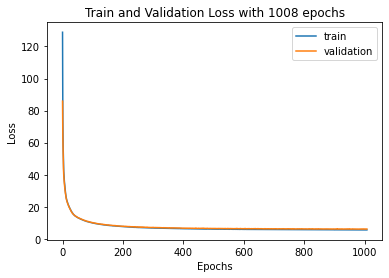

In [19]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [21]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

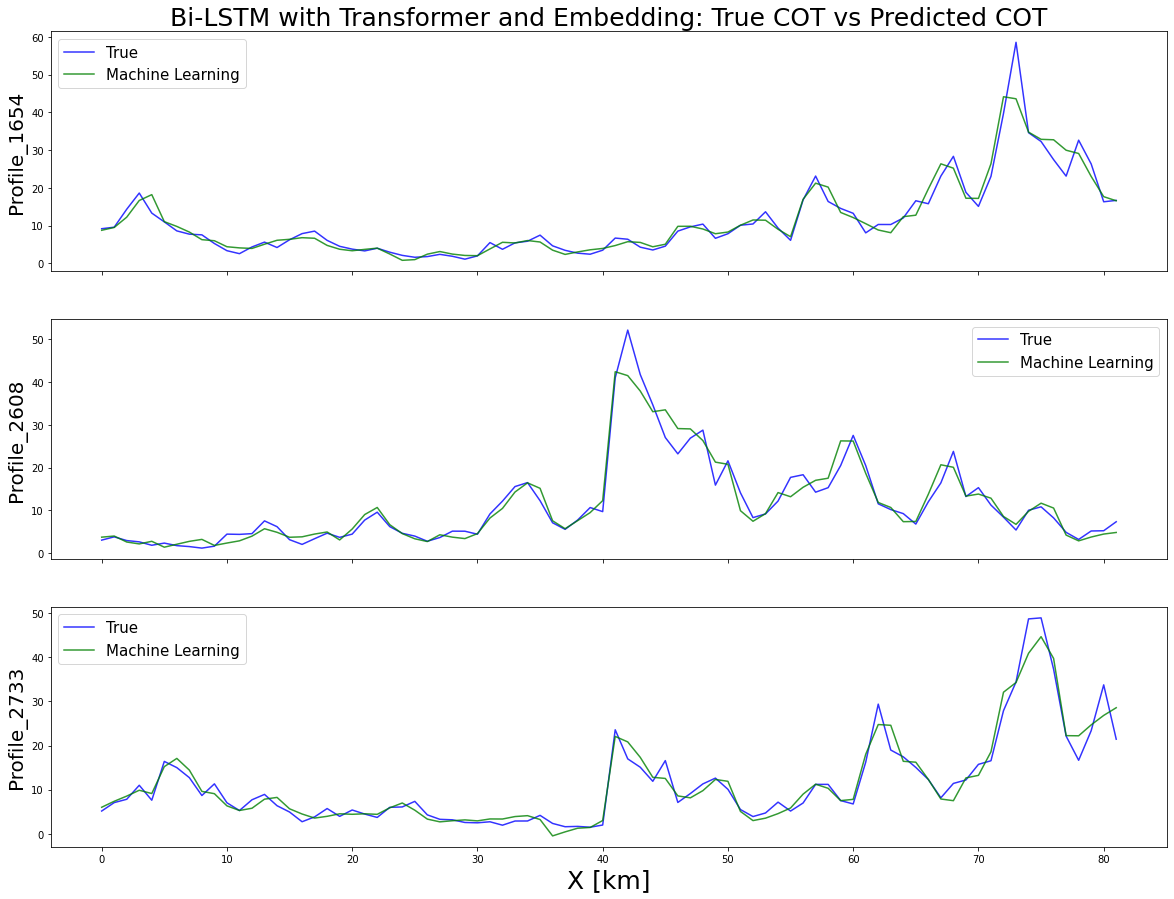

In [23]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_DNN"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer and Embedding: True COT vs Predicted COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_1654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_2608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_2733",fontsize=20)  
ax.set_xlabel('X [km]',fontsize=25)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [24]:
cot=np.load('cot_500m.npy')

In [25]:
for i in range(4000):
    if np.array_equal(c[num-1],cot[i]):
        print(i+1)

2733


In [26]:
for i in range(4000):
    if np.array_equal(c[num-2],cot[i]):
        print(i+1)

2608


In [27]:
for i in range(4000):
    if np.array_equal(c[num-3],cot[i]):
        print(i+1)

1654
